In [2]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [3]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [4]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_Train_with_TRUE_85500inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=190)
(2479500, 190)


In [5]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']>8])
print(view_1hot_df.shape[0]/20)
# Take 85500 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:, :-7].values)
print(train_v.shape)
print(train_v.shape[0]/20)

Number of inds: 85500
85500.0
85500.0
(1710000, 182)
85500.0


In [6]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 

In [7]:
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
#print('Unique LL_PDC:', np.unique(train_v[:, 28]))

LL_PDC: 28


In [8]:
def setup_xy(time_series_v, scaled_v, obs_steps):
    # make x_train and y_train
    num_of_inds = time_series_v.shape[0]//20
    print("Number of inds:", num_of_inds)
    num_of_features = time_series_v.shape[1]
    print("Number of features:", num_of_features)

    x_ = np.empty((num_of_inds, obs_steps, num_of_features))
    # creating 2 binary vectors for softmax 
    # non-adherent and adherent
    y_ = np.empty((num_of_inds, 2))

    for i in range(num_of_inds):
        ind_v = time_series_v[(i*20):((i+1)*20), :]
        if sum(ind_v[16:20, 28])/4 >= 80:
            y_[i, 0] = 0.0
            y_[i, 1] = 1.0
        else:
            y_[i, 0] = 1.0
            y_[i, 1] = 0.0
        scaled_ind_v = scaled_v[(i*20):((i+1)*20), :]
        x_[i] = scaled_ind_v[(16-obs_steps):16, :]
    return x_, y_

In [9]:
x_train, y_train = setup_xy(train_v, scaled_train, 8)
print(x_train.shape)
print(y_train.shape)

Number of inds: 85500
Number of features: 182
(85500, 8, 182)
(85500, 2)


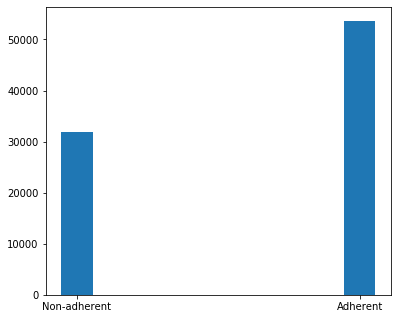

In [15]:
pyplot.rcParams.update({'font.size': 10})
pyplot.figure(figsize=(8,5))
pyplot.subplot(111)
pyplot.hist(y_train[:, 1], bins=10)
pyplot.xticks([0.05, 0.95], ["Non-adherent", "Adherent"])
pyplot.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.7, hspace=0.4, wspace=0.2)
pyplot.show()

In [10]:
num_per_fold = x_train.shape[0]//10
print(num_per_fold)

8550


8550
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.6677 - acc: 0.7576 - val_loss: 0.4410 - val_acc: 0.8585

Epoch 00001: val_loss improved from inf to 0.44104, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.3925 - acc: 0.8672 - val_loss: 0.3738 - val_acc: 0.8708

Epoch 00002: val_loss improved from 0.44104 to 0.37378, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.3557 - acc: 0.8704 - val_loss: 0.3543 - val_acc: 0.8708

Epoch 00003: val_loss improved from 0.37378 to 0.35429, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.3419 - acc: 0.8713 - val_loss: 0.3455 - val_acc: 0.8715

Epoch 00004: val_loss improved from 0.35429 to 0.34548, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.3354 - acc: 0.8721 - val_loss: 0.3407 - val_acc: 0.8718

Epoch 00005: val_loss imp


Epoch 00052: val_loss did not improve from 0.33344
Epoch 53/100
 - 1s - loss: 0.3185 - acc: 0.8765 - val_loss: 0.3421 - val_acc: 0.8689

Epoch 00053: val_loss did not improve from 0.33344
Epoch 54/100
 - 1s - loss: 0.3184 - acc: 0.8765 - val_loss: 0.3421 - val_acc: 0.8691

Epoch 00054: val_loss did not improve from 0.33344
Epoch 55/100
 - 1s - loss: 0.3182 - acc: 0.8767 - val_loss: 0.3424 - val_acc: 0.8697

Epoch 00055: val_loss did not improve from 0.33344
Epoch 56/100
 - 1s - loss: 0.3183 - acc: 0.8769 - val_loss: 0.3423 - val_acc: 0.8691

Epoch 00056: val_loss did not improve from 0.33344
Epoch 57/100
 - 1s - loss: 0.3180 - acc: 0.8770 - val_loss: 0.3425 - val_acc: 0.8692

Epoch 00057: val_loss did not improve from 0.33344
Epoch 58/100
 - 1s - loss: 0.3181 - acc: 0.8770 - val_loss: 0.3421 - val_acc: 0.8688

Epoch 00058: val_loss did not improve from 0.33344
Epoch 59/100
 - 1s - loss: 0.3180 - acc: 0.8768 - val_loss: 0.3420 - val_acc: 0.8694

Epoch 00059: val_loss did not improve fr

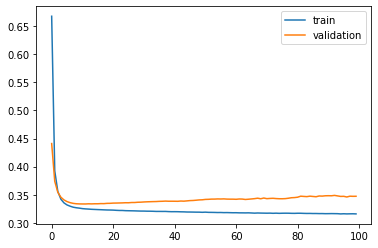

Time to train LSTM:  142.1764349937439
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.6700 - acc: 0.7562 - val_loss: 0.4351 - val_acc: 0.8655

Epoch 00001: val_loss improved from inf to 0.43512, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.3930 - acc: 0.8669 - val_loss: 0.3710 - val_acc: 0.8703

Epoch 00002: val_loss improved from 0.43512 to 0.37100, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.3555 - acc: 0.8698 - val_loss: 0.3520 - val_acc: 0.8717

Epoch 00003: val_loss improved from 0.37100 to 0.35203, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.3418 - acc: 0.8713 - val_loss: 0.3435 - val_acc: 0.8719

Epoch 00004: val_loss improved from 0.35203 to 0.34354, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.3350 - acc: 0.8719 - val_loss: 0.3391 - val_acc: 0.8718

Epoch 00005: val_loss improved from 0.34354 to 0.33915, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3180 - acc: 0.8764 - val_loss: 0.3416 - val_acc: 0.8667

Epoch 00057: val_loss did not improve from 0.33366
Epoch 58/100
 - 1s - loss: 0.3182 - acc: 0.8767 - val_loss: 0.3422 - val_acc: 0.8660

Epoch 00058: val_loss did not improve from 0.33366
Epoch 59/100
 - 1s - loss: 0.3180 - acc: 0.8766 - val_loss: 0.3422 - val_acc: 0.8674

Epoch 00059: val_loss did not improve from 0.33366
Epoch 60/100
 - 1s - loss: 0.3179 - acc: 0.8767 - val_loss: 0.3418 - val_acc: 0.8668

Epoch 00060: val_loss did not improve from 0.33366
Epoch 61/100
 - 1s - loss: 0.3177 - acc: 0.8769 - val_loss: 0.3427 - val_acc: 0.8676

Epoch 00061: val_loss did not improve from 0.33366
Epoch 62/100
 - 1s - loss: 0.3177 - acc: 0.8769 - val_loss: 0.3423 - val_acc: 0.8685

Epoch 00062: val_loss did not improve from 0.33366
Epoch 63/100
 - 1s - loss: 0.3177 - acc: 0.8768 - val_loss: 0.3430 - val_acc: 0.8682

Epoch 00063: val_loss did not improve from 0.33366
Epoch 64/100
 - 1s - loss: 0.3176 - acc: 0.8771 - val_

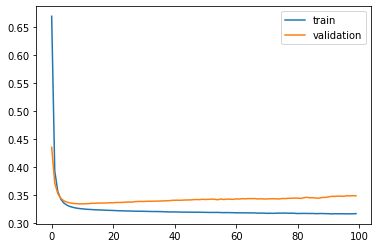

Time to train LSTM:  141.16710019111633
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.6681 - acc: 0.7569 - val_loss: 0.4475 - val_acc: 0.8503

Epoch 00001: val_loss improved from inf to 0.44751, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.3920 - acc: 0.8674 - val_loss: 0.3770 - val_acc: 0.8623

Epoch 00002: val_loss improved from 0.44751 to 0.37704, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.3550 - acc: 0.8711 - val_loss: 0.3571 - val_acc: 0.8642

Epoch 00003: val_loss improved from 0.37704 to 0.35713, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.3413 - acc: 0.8721 - val_loss: 0.3487 - val_acc: 0.8644

Epoch 00004: val_loss improved from 0.35713 to 0.34875, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.3346 - acc: 0.8727 - val_loss: 0.3444 - val_acc: 0.8648

Epoch 00005: val_loss improved from 0.34875 to 0.34439, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 


Epoch 00057: val_loss did not improve from 0.33919
Epoch 58/100
 - 1s - loss: 0.3173 - acc: 0.8761 - val_loss: 0.3458 - val_acc: 0.8632

Epoch 00058: val_loss did not improve from 0.33919
Epoch 59/100
 - 1s - loss: 0.3174 - acc: 0.8758 - val_loss: 0.3456 - val_acc: 0.8633

Epoch 00059: val_loss did not improve from 0.33919
Epoch 60/100
 - 1s - loss: 0.3172 - acc: 0.8760 - val_loss: 0.3454 - val_acc: 0.8634

Epoch 00060: val_loss did not improve from 0.33919
Epoch 61/100
 - 1s - loss: 0.3173 - acc: 0.8762 - val_loss: 0.3456 - val_acc: 0.8633

Epoch 00061: val_loss did not improve from 0.33919
Epoch 62/100
 - 1s - loss: 0.3172 - acc: 0.8764 - val_loss: 0.3455 - val_acc: 0.8632

Epoch 00062: val_loss did not improve from 0.33919
Epoch 63/100
 - 1s - loss: 0.3171 - acc: 0.8761 - val_loss: 0.3454 - val_acc: 0.8630

Epoch 00063: val_loss did not improve from 0.33919
Epoch 64/100
 - 1s - loss: 0.3168 - acc: 0.8763 - val_loss: 0.3460 - val_acc: 0.8626

Epoch 00064: val_loss did not improve fr

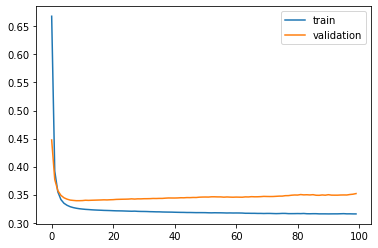

Time to train LSTM:  142.96739745140076


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f68c0792b00>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.6715 - acc: 0.7559 - val_loss: 0.4379 - val_acc: 0.8604

Epoch 00001: val_loss improved from inf to 0.43795, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.3932 - acc: 0.8668 - val_loss: 0.3704 - val_acc: 0.8709

Epoch 00002: val_loss improved from 0.43795 to 0.37044, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.3559 - acc: 0.8701 - val_loss: 0.3504 - val_acc: 0.8711

Epoch 00003: val_loss improved from 0.37044 to 0.35038, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.3425 - acc: 0.8708 - val_loss: 0.3417 - val_acc: 0.8718

Epoch 00004: val_loss improved from 0.35038 to 0.34171, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.3357 - acc: 0.8718 - val_loss: 0.3375 - val_acc: 0.8720

Epoch 00005: val_loss improved from 0.34171 to 0.33748, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.3321 - acc: 0.8720 - val_lo


Epoch 00057: val_loss did not improve from 0.33341
Epoch 58/100
 - 1s - loss: 0.3184 - acc: 0.8757 - val_loss: 0.3438 - val_acc: 0.8678

Epoch 00058: val_loss did not improve from 0.33341
Epoch 59/100
 - 1s - loss: 0.3183 - acc: 0.8760 - val_loss: 0.3437 - val_acc: 0.8681

Epoch 00059: val_loss did not improve from 0.33341
Epoch 60/100
 - 1s - loss: 0.3182 - acc: 0.8758 - val_loss: 0.3443 - val_acc: 0.8688

Epoch 00060: val_loss did not improve from 0.33341
Epoch 61/100
 - 1s - loss: 0.3182 - acc: 0.8757 - val_loss: 0.3444 - val_acc: 0.8684

Epoch 00061: val_loss did not improve from 0.33341
Epoch 62/100
 - 1s - loss: 0.3180 - acc: 0.8761 - val_loss: 0.3435 - val_acc: 0.8682

Epoch 00062: val_loss did not improve from 0.33341
Epoch 63/100
 - 1s - loss: 0.3179 - acc: 0.8764 - val_loss: 0.3437 - val_acc: 0.8688

Epoch 00063: val_loss did not improve from 0.33341
Epoch 64/100
 - 1s - loss: 0.3180 - acc: 0.8765 - val_loss: 0.3444 - val_acc: 0.8684

Epoch 00064: val_loss did not improve fr

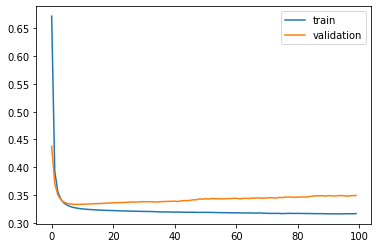

Time to train LSTM:  144.25877285003662
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.6693 - acc: 0.7579 - val_loss: 0.4450 - val_acc: 0.8554

Epoch 00001: val_loss improved from inf to 0.44501, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.3917 - acc: 0.8676 - val_loss: 0.3778 - val_acc: 0.8634

Epoch 00002: val_loss improved from 0.44501 to 0.37783, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.3543 - acc: 0.8712 - val_loss: 0.3581 - val_acc: 0.8641

Epoch 00003: val_loss improved from 0.37783 to 0.35809, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.3407 - acc: 0.8722 - val_loss: 0.3493 - val_acc: 0.8643

Epoch 00004: val_loss improved from 0.35809 to 0.34932, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.3344 - acc: 0.8725 - val_loss: 0.3451 - val_acc: 0.8654

Epoch 00005: val_loss improved from 0.34932 to 0.34506, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 


Epoch 00056: val_loss did not improve from 0.33941
Epoch 57/100
 - 1s - loss: 0.3176 - acc: 0.8767 - val_loss: 0.3465 - val_acc: 0.8648

Epoch 00057: val_loss did not improve from 0.33941
Epoch 58/100
 - 1s - loss: 0.3175 - acc: 0.8772 - val_loss: 0.3466 - val_acc: 0.8646

Epoch 00058: val_loss did not improve from 0.33941
Epoch 59/100
 - 1s - loss: 0.3172 - acc: 0.8770 - val_loss: 0.3472 - val_acc: 0.8653

Epoch 00059: val_loss did not improve from 0.33941
Epoch 60/100
 - 1s - loss: 0.3169 - acc: 0.8769 - val_loss: 0.3477 - val_acc: 0.8647

Epoch 00060: val_loss did not improve from 0.33941
Epoch 61/100
 - 1s - loss: 0.3168 - acc: 0.8769 - val_loss: 0.3479 - val_acc: 0.8649

Epoch 00061: val_loss did not improve from 0.33941
Epoch 62/100
 - 1s - loss: 0.3170 - acc: 0.8771 - val_loss: 0.3482 - val_acc: 0.8646

Epoch 00062: val_loss did not improve from 0.33941
Epoch 63/100
 - 1s - loss: 0.3168 - acc: 0.8772 - val_loss: 0.3485 - val_acc: 0.8641

Epoch 00063: val_loss did not improve fr

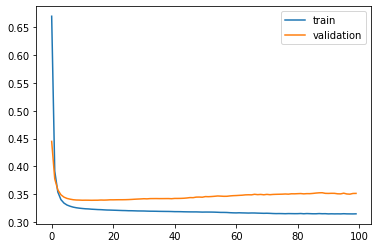

Time to train LSTM:  144.28396797180176


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f68b4630470>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.8190 - acc: 0.6818 - val_loss: 0.5790 - val_acc: 0.8097

Epoch 00001: val_loss improved from inf to 0.57898, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.4739 - acc: 0.8485 - val_loss: 0.4201 - val_acc: 0.8614

Epoch 00002: val_loss improved from 0.57898 to 0.42007, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.3891 - acc: 0.8667 - val_loss: 0.3799 - val_acc: 0.8678

Epoch 00003: val_loss improved from 0.42007 to 0.37993, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.3616 - acc: 0.8702 - val_loss: 0.3620 - val_acc: 0.8704

Epoch 00004: val_loss improved from 0.37993 to 0.36204, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.3481 - acc: 0.8712 - val_loss: 0.3524 - val_acc: 0.8703

Epoch 00005: val_loss improved from 0.36204 to 0.35238, saving model to Post_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.3404 - acc: 0.8720 - val_lo

 - 1s - loss: 0.3156 - acc: 0.8766 - val_loss: 0.3396 - val_acc: 0.8665

Epoch 00055: val_loss did not improve from 0.33315
Epoch 56/100
 - 1s - loss: 0.3153 - acc: 0.8765 - val_loss: 0.3400 - val_acc: 0.8667

Epoch 00056: val_loss did not improve from 0.33315
Epoch 57/100
 - 1s - loss: 0.3152 - acc: 0.8767 - val_loss: 0.3400 - val_acc: 0.8668

Epoch 00057: val_loss did not improve from 0.33315
Epoch 58/100
 - 1s - loss: 0.3150 - acc: 0.8768 - val_loss: 0.3404 - val_acc: 0.8668

Epoch 00058: val_loss did not improve from 0.33315
Epoch 59/100
 - 1s - loss: 0.3149 - acc: 0.8769 - val_loss: 0.3404 - val_acc: 0.8669

Epoch 00059: val_loss did not improve from 0.33315
Epoch 60/100
 - 1s - loss: 0.3148 - acc: 0.8771 - val_loss: 0.3406 - val_acc: 0.8671

Epoch 00060: val_loss did not improve from 0.33315
Epoch 61/100
 - 1s - loss: 0.3147 - acc: 0.8769 - val_loss: 0.3407 - val_acc: 0.8671

Epoch 00061: val_loss did not improve from 0.33315
Epoch 62/100
 - 1s - loss: 0.3145 - acc: 0.8769 - val_

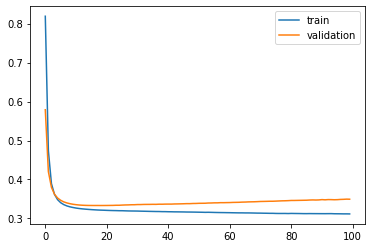

Time to train LSTM:  92.8881402015686
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.8210 - acc: 0.6780 - val_loss: 0.5730 - val_acc: 0.8213

Epoch 00001: val_loss improved from inf to 0.57302, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.4756 - acc: 0.8477 - val_loss: 0.4141 - val_acc: 0.8654

Epoch 00002: val_loss improved from 0.57302 to 0.41412, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.3887 - acc: 0.8671 - val_loss: 0.3762 - val_acc: 0.8718

Epoch 00003: val_loss improved from 0.41412 to 0.37622, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.3612 - acc: 0.8703 - val_loss: 0.3594 - val_acc: 0.8727

Epoch 00004: val_loss improved from 0.37622 to 0.35937, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.3478 - acc: 0.8714 - val_loss: 0.3505 - val_acc: 0.8745

Epoch 00005: val_loss improved from 0.35937 to 0.35049, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 1s

 - 1s - loss: 0.3144 - acc: 0.8781 - val_loss: 0.3425 - val_acc: 0.8663

Epoch 00055: val_loss did not improve from 0.33298
Epoch 56/100
 - 1s - loss: 0.3141 - acc: 0.8783 - val_loss: 0.3426 - val_acc: 0.8669

Epoch 00056: val_loss did not improve from 0.33298
Epoch 57/100
 - 1s - loss: 0.3141 - acc: 0.8779 - val_loss: 0.3428 - val_acc: 0.8675

Epoch 00057: val_loss did not improve from 0.33298
Epoch 58/100
 - 1s - loss: 0.3139 - acc: 0.8779 - val_loss: 0.3433 - val_acc: 0.8669

Epoch 00058: val_loss did not improve from 0.33298
Epoch 59/100
 - 1s - loss: 0.3136 - acc: 0.8781 - val_loss: 0.3439 - val_acc: 0.8662

Epoch 00059: val_loss did not improve from 0.33298
Epoch 60/100
 - 1s - loss: 0.3135 - acc: 0.8781 - val_loss: 0.3440 - val_acc: 0.8664

Epoch 00060: val_loss did not improve from 0.33298
Epoch 61/100
 - 1s - loss: 0.3133 - acc: 0.8783 - val_loss: 0.3445 - val_acc: 0.8656

Epoch 00061: val_loss did not improve from 0.33298
Epoch 62/100
 - 1s - loss: 0.3132 - acc: 0.8783 - val_

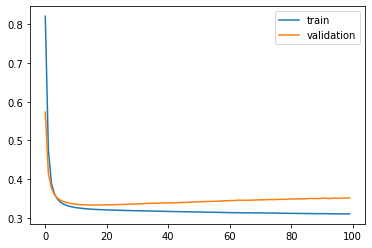

Time to train LSTM:  90.99193453788757


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f68841d30b8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.8194 - acc: 0.6808 - val_loss: 0.5828 - val_acc: 0.8097

Epoch 00001: val_loss improved from inf to 0.58279, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.4744 - acc: 0.8490 - val_loss: 0.4253 - val_acc: 0.8553

Epoch 00002: val_loss improved from 0.58279 to 0.42535, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.3885 - acc: 0.8680 - val_loss: 0.3825 - val_acc: 0.8618

Epoch 00003: val_loss improved from 0.42535 to 0.38247, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.3608 - acc: 0.8714 - val_loss: 0.3645 - val_acc: 0.8632

Epoch 00004: val_loss improved from 0.38247 to 0.36453, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.3472 - acc: 0.8725 - val_loss: 0.3553 - val_acc: 0.8642

Epoch 00005: val_loss improved from 0.36453 to 0.35528, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.3393 - acc: 0.8734 - val_lo


Epoch 00055: val_loss did not improve from 0.33947
Epoch 56/100
 - 1s - loss: 0.3141 - acc: 0.8772 - val_loss: 0.3486 - val_acc: 0.8630

Epoch 00056: val_loss did not improve from 0.33947
Epoch 57/100
 - 1s - loss: 0.3141 - acc: 0.8773 - val_loss: 0.3488 - val_acc: 0.8635

Epoch 00057: val_loss did not improve from 0.33947
Epoch 58/100
 - 1s - loss: 0.3140 - acc: 0.8778 - val_loss: 0.3489 - val_acc: 0.8630

Epoch 00058: val_loss did not improve from 0.33947
Epoch 59/100
 - 1s - loss: 0.3140 - acc: 0.8780 - val_loss: 0.3493 - val_acc: 0.8633

Epoch 00059: val_loss did not improve from 0.33947
Epoch 60/100
 - 1s - loss: 0.3140 - acc: 0.8782 - val_loss: 0.3495 - val_acc: 0.8635

Epoch 00060: val_loss did not improve from 0.33947
Epoch 61/100
 - 1s - loss: 0.3139 - acc: 0.8780 - val_loss: 0.3493 - val_acc: 0.8628

Epoch 00061: val_loss did not improve from 0.33947
Epoch 62/100
 - 1s - loss: 0.3138 - acc: 0.8781 - val_loss: 0.3497 - val_acc: 0.8628

Epoch 00062: val_loss did not improve fr

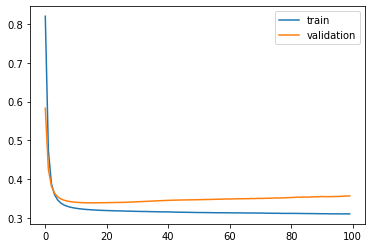

Time to train LSTM:  91.96296525001526
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.8216 - acc: 0.6792 - val_loss: 0.5808 - val_acc: 0.8127

Epoch 00001: val_loss improved from inf to 0.58084, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.4762 - acc: 0.8469 - val_loss: 0.4143 - val_acc: 0.8632

Epoch 00002: val_loss improved from 0.58084 to 0.41434, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.3887 - acc: 0.8674 - val_loss: 0.3740 - val_acc: 0.8705

Epoch 00003: val_loss improved from 0.41434 to 0.37399, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.3614 - acc: 0.8703 - val_loss: 0.3572 - val_acc: 0.8712

Epoch 00004: val_loss improved from 0.37399 to 0.35717, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.3481 - acc: 0.8711 - val_loss: 0.3480 - val_acc: 0.8723

Epoch 00005: val_loss improved from 0.35717 to 0.34799, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 1


Epoch 00055: val_loss did not improve from 0.33222
Epoch 56/100
 - 1s - loss: 0.3149 - acc: 0.8765 - val_loss: 0.3400 - val_acc: 0.8674

Epoch 00056: val_loss did not improve from 0.33222
Epoch 57/100
 - 1s - loss: 0.3147 - acc: 0.8768 - val_loss: 0.3403 - val_acc: 0.8673

Epoch 00057: val_loss did not improve from 0.33222
Epoch 58/100
 - 1s - loss: 0.3146 - acc: 0.8770 - val_loss: 0.3405 - val_acc: 0.8668

Epoch 00058: val_loss did not improve from 0.33222
Epoch 59/100
 - 1s - loss: 0.3145 - acc: 0.8769 - val_loss: 0.3409 - val_acc: 0.8668

Epoch 00059: val_loss did not improve from 0.33222
Epoch 60/100
 - 1s - loss: 0.3145 - acc: 0.8771 - val_loss: 0.3409 - val_acc: 0.8665

Epoch 00060: val_loss did not improve from 0.33222
Epoch 61/100
 - 1s - loss: 0.3143 - acc: 0.8773 - val_loss: 0.3410 - val_acc: 0.8662

Epoch 00061: val_loss did not improve from 0.33222
Epoch 62/100
 - 1s - loss: 0.3142 - acc: 0.8773 - val_loss: 0.3418 - val_acc: 0.8658

Epoch 00062: val_loss did not improve fr

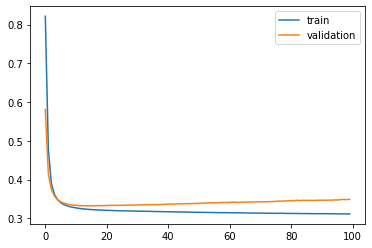

Time to train LSTM:  91.5160973072052


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f684c5c8470>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 4s - loss: 0.8208 - acc: 0.6792 - val_loss: 0.5771 - val_acc: 0.8173

Epoch 00001: val_loss improved from inf to 0.57710, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.4733 - acc: 0.8484 - val_loss: 0.4225 - val_acc: 0.8577

Epoch 00002: val_loss improved from 0.57710 to 0.42254, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.3877 - acc: 0.8681 - val_loss: 0.3823 - val_acc: 0.8628

Epoch 00003: val_loss improved from 0.42254 to 0.38226, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.3602 - acc: 0.8711 - val_loss: 0.3644 - val_acc: 0.8625

Epoch 00004: val_loss improved from 0.38226 to 0.36439, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.3469 - acc: 0.8724 - val_loss: 0.3550 - val_acc: 0.8627

Epoch 00005: val_loss improved from 0.36439 to 0.35504, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.3392 - acc: 0.8729 - val_lo

 - 1s - loss: 0.3145 - acc: 0.8776 - val_loss: 0.3464 - val_acc: 0.8620

Epoch 00055: val_loss did not improve from 0.33805
Epoch 56/100
 - 1s - loss: 0.3144 - acc: 0.8776 - val_loss: 0.3469 - val_acc: 0.8626

Epoch 00056: val_loss did not improve from 0.33805
Epoch 57/100
 - 1s - loss: 0.3141 - acc: 0.8776 - val_loss: 0.3468 - val_acc: 0.8620

Epoch 00057: val_loss did not improve from 0.33805
Epoch 58/100
 - 1s - loss: 0.3140 - acc: 0.8777 - val_loss: 0.3474 - val_acc: 0.8615

Epoch 00058: val_loss did not improve from 0.33805
Epoch 59/100
 - 1s - loss: 0.3139 - acc: 0.8778 - val_loss: 0.3477 - val_acc: 0.8619

Epoch 00059: val_loss did not improve from 0.33805
Epoch 60/100
 - 1s - loss: 0.3138 - acc: 0.8778 - val_loss: 0.3477 - val_acc: 0.8623

Epoch 00060: val_loss did not improve from 0.33805
Epoch 61/100
 - 1s - loss: 0.3137 - acc: 0.8780 - val_loss: 0.3478 - val_acc: 0.8626

Epoch 00061: val_loss did not improve from 0.33805
Epoch 62/100
 - 1s - loss: 0.3137 - acc: 0.8779 - val_

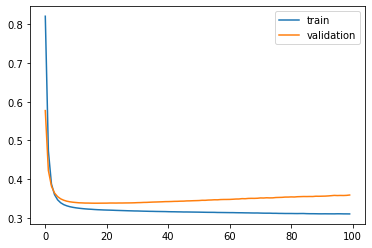

Time to train LSTM:  93.22500324249268
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 3s - loss: 0.9589 - acc: 0.5906 - val_loss: 0.7640 - val_acc: 0.7196

Epoch 00001: val_loss improved from inf to 0.76403, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6522 - acc: 0.7819 - val_loss: 0.5588 - val_acc: 0.8180

Epoch 00002: val_loss improved from 0.76403 to 0.55875, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.4900 - acc: 0.8434 - val_loss: 0.4491 - val_acc: 0.8531

Epoch 00003: val_loss improved from 0.55875 to 0.44906, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.4155 - acc: 0.8630 - val_loss: 0.4016 - val_acc: 0.8646

Epoch 00004: val_loss improved from 0.44906 to 0.40160, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.3823 - acc: 0.8688 - val_loss: 0.3786 - val_acc: 0.8670

Epoch 00005: val_loss improved from 0.40160 to 0.37856, saving model to Post_val_weights1.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3131 - acc: 0.8772 - val_loss: 0.3340 - val_acc: 0.8702

Epoch 00052: val_loss did not improve from 0.32902
Epoch 53/100
 - 1s - loss: 0.3129 - acc: 0.8772 - val_loss: 0.3341 - val_acc: 0.8701

Epoch 00053: val_loss did not improve from 0.32902
Epoch 54/100
 - 1s - loss: 0.3128 - acc: 0.8771 - val_loss: 0.3345 - val_acc: 0.8695

Epoch 00054: val_loss did not improve from 0.32902
Epoch 55/100
 - 1s - loss: 0.3126 - acc: 0.8771 - val_loss: 0.3348 - val_acc: 0.8690

Epoch 00055: val_loss did not improve from 0.32902
Epoch 56/100
 - 1s - loss: 0.3124 - acc: 0.8772 - val_loss: 0.3349 - val_acc: 0.8691

Epoch 00056: val_loss did not improve from 0.32902
Epoch 57/100
 - 1s - loss: 0.3122 - acc: 0.8773 - val_loss: 0.3351 - val_acc: 0.8687

Epoch 00057: val_loss did not improve from 0.32902
Epoch 58/100
 - 1s - loss: 0.3121 - acc: 0.8774 - val_loss: 0.3353 - val_acc: 0.8692

Epoch 00058: val_loss did not improve from 0.32902
Epoch 59/100
 - 1s - loss: 0.3119 - acc: 0.8774 - val_

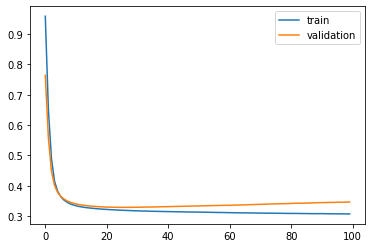

Time to train LSTM:  63.736597299575806
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 3s - loss: 0.9595 - acc: 0.5902 - val_loss: 0.7612 - val_acc: 0.7339

Epoch 00001: val_loss improved from inf to 0.76119, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6536 - acc: 0.7801 - val_loss: 0.5502 - val_acc: 0.8282

Epoch 00002: val_loss improved from 0.76119 to 0.55016, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.4909 - acc: 0.8425 - val_loss: 0.4422 - val_acc: 0.8601

Epoch 00003: val_loss improved from 0.55016 to 0.44218, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.4161 - acc: 0.8629 - val_loss: 0.3989 - val_acc: 0.8676

Epoch 00004: val_loss improved from 0.44218 to 0.39891, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.3826 - acc: 0.8682 - val_loss: 0.3776 - val_acc: 0.8711

Epoch 00005: val_loss improved from 0.39891 to 0.37764, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 


Epoch 00052: val_loss did not improve from 0.33129
Epoch 53/100
 - 1s - loss: 0.3131 - acc: 0.8776 - val_loss: 0.3368 - val_acc: 0.8669

Epoch 00053: val_loss did not improve from 0.33129
Epoch 54/100
 - 1s - loss: 0.3130 - acc: 0.8775 - val_loss: 0.3372 - val_acc: 0.8669

Epoch 00054: val_loss did not improve from 0.33129
Epoch 55/100
 - 1s - loss: 0.3128 - acc: 0.8776 - val_loss: 0.3373 - val_acc: 0.8673

Epoch 00055: val_loss did not improve from 0.33129
Epoch 56/100
 - 1s - loss: 0.3126 - acc: 0.8777 - val_loss: 0.3377 - val_acc: 0.8673

Epoch 00056: val_loss did not improve from 0.33129
Epoch 57/100
 - 1s - loss: 0.3126 - acc: 0.8776 - val_loss: 0.3380 - val_acc: 0.8671

Epoch 00057: val_loss did not improve from 0.33129
Epoch 58/100
 - 1s - loss: 0.3124 - acc: 0.8777 - val_loss: 0.3384 - val_acc: 0.8668

Epoch 00058: val_loss did not improve from 0.33129
Epoch 59/100
 - 1s - loss: 0.3123 - acc: 0.8779 - val_loss: 0.3387 - val_acc: 0.8668

Epoch 00059: val_loss did not improve fr

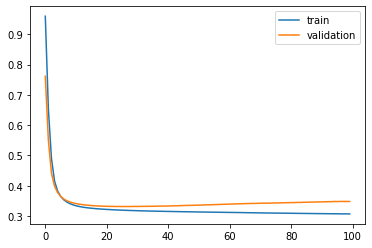

Time to train LSTM:  63.621875524520874
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 3s - loss: 0.9586 - acc: 0.5906 - val_loss: 0.7693 - val_acc: 0.7191

Epoch 00001: val_loss improved from inf to 0.76927, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6529 - acc: 0.7809 - val_loss: 0.5616 - val_acc: 0.8171

Epoch 00002: val_loss improved from 0.76927 to 0.56159, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.4901 - acc: 0.8437 - val_loss: 0.4560 - val_acc: 0.8477

Epoch 00003: val_loss improved from 0.56159 to 0.45596, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.4154 - acc: 0.8640 - val_loss: 0.4084 - val_acc: 0.8588

Epoch 00004: val_loss improved from 0.45596 to 0.40842, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.3819 - acc: 0.8684 - val_loss: 0.3842 - val_acc: 0.8629

Epoch 00005: val_loss improved from 0.40842 to 0.38416, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 

 - 1s - loss: 0.3121 - acc: 0.8776 - val_loss: 0.3446 - val_acc: 0.8635

Epoch 00052: val_loss did not improve from 0.33793
Epoch 53/100
 - 1s - loss: 0.3118 - acc: 0.8776 - val_loss: 0.3449 - val_acc: 0.8641

Epoch 00053: val_loss did not improve from 0.33793
Epoch 54/100
 - 1s - loss: 0.3117 - acc: 0.8777 - val_loss: 0.3451 - val_acc: 0.8639

Epoch 00054: val_loss did not improve from 0.33793
Epoch 55/100
 - 1s - loss: 0.3115 - acc: 0.8778 - val_loss: 0.3453 - val_acc: 0.8636

Epoch 00055: val_loss did not improve from 0.33793
Epoch 56/100
 - 1s - loss: 0.3113 - acc: 0.8779 - val_loss: 0.3456 - val_acc: 0.8636

Epoch 00056: val_loss did not improve from 0.33793
Epoch 57/100
 - 1s - loss: 0.3112 - acc: 0.8780 - val_loss: 0.3461 - val_acc: 0.8637

Epoch 00057: val_loss did not improve from 0.33793
Epoch 58/100
 - 1s - loss: 0.3110 - acc: 0.8782 - val_loss: 0.3460 - val_acc: 0.8637

Epoch 00058: val_loss did not improve from 0.33793
Epoch 59/100
 - 1s - loss: 0.3108 - acc: 0.8781 - val_

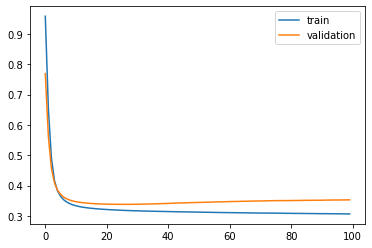

Time to train LSTM:  65.31690096855164


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f6844142710>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 3s - loss: 0.9598 - acc: 0.5891 - val_loss: 0.7731 - val_acc: 0.7168

Epoch 00001: val_loss improved from inf to 0.77306, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6537 - acc: 0.7809 - val_loss: 0.5566 - val_acc: 0.8221

Epoch 00002: val_loss improved from 0.77306 to 0.55662, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.4914 - acc: 0.8426 - val_loss: 0.4446 - val_acc: 0.8585

Epoch 00003: val_loss improved from 0.55662 to 0.44458, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.4160 - acc: 0.8632 - val_loss: 0.3984 - val_acc: 0.8677

Epoch 00004: val_loss improved from 0.44458 to 0.39837, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.3822 - acc: 0.8683 - val_loss: 0.3753 - val_acc: 0.8695

Epoch 00005: val_loss improved from 0.39837 to 0.37527, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.3643 - acc: 0.8702 - val_lo


Epoch 00053: val_loss did not improve from 0.33040
Epoch 54/100
 - 1s - loss: 0.3124 - acc: 0.8771 - val_loss: 0.3371 - val_acc: 0.8688

Epoch 00054: val_loss did not improve from 0.33040
Epoch 55/100
 - 1s - loss: 0.3122 - acc: 0.8771 - val_loss: 0.3372 - val_acc: 0.8689

Epoch 00055: val_loss did not improve from 0.33040
Epoch 56/100
 - 1s - loss: 0.3120 - acc: 0.8771 - val_loss: 0.3376 - val_acc: 0.8688

Epoch 00056: val_loss did not improve from 0.33040
Epoch 57/100
 - 1s - loss: 0.3119 - acc: 0.8771 - val_loss: 0.3380 - val_acc: 0.8691

Epoch 00057: val_loss did not improve from 0.33040
Epoch 58/100
 - 1s - loss: 0.3117 - acc: 0.8772 - val_loss: 0.3381 - val_acc: 0.8687

Epoch 00058: val_loss did not improve from 0.33040
Epoch 59/100
 - 1s - loss: 0.3116 - acc: 0.8774 - val_loss: 0.3384 - val_acc: 0.8685

Epoch 00059: val_loss did not improve from 0.33040
Epoch 60/100
 - 1s - loss: 0.3114 - acc: 0.8777 - val_loss: 0.3386 - val_acc: 0.8685

Epoch 00060: val_loss did not improve fr

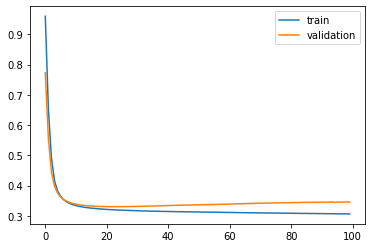

Time to train LSTM:  65.03043818473816
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 4s - loss: 0.9601 - acc: 0.5897 - val_loss: 0.7683 - val_acc: 0.7214

Epoch 00001: val_loss improved from inf to 0.76834, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6521 - acc: 0.7826 - val_loss: 0.5559 - val_acc: 0.8199

Epoch 00002: val_loss improved from 0.76834 to 0.55588, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.4890 - acc: 0.8443 - val_loss: 0.4512 - val_acc: 0.8522

Epoch 00003: val_loss improved from 0.55588 to 0.45123, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.4147 - acc: 0.8634 - val_loss: 0.4058 - val_acc: 0.8609

Epoch 00004: val_loss improved from 0.45123 to 0.40580, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.3812 - acc: 0.8684 - val_loss: 0.3831 - val_acc: 0.8630

Epoch 00005: val_loss improved from 0.40580 to 0.38307, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3122 - acc: 0.8774 - val_loss: 0.3395 - val_acc: 0.8651

Epoch 00051: val_loss did not improve from 0.33539
Epoch 52/100
 - 1s - loss: 0.3121 - acc: 0.8775 - val_loss: 0.3398 - val_acc: 0.8649

Epoch 00052: val_loss did not improve from 0.33539
Epoch 53/100
 - 1s - loss: 0.3119 - acc: 0.8775 - val_loss: 0.3402 - val_acc: 0.8649

Epoch 00053: val_loss did not improve from 0.33539
Epoch 54/100
 - 1s - loss: 0.3117 - acc: 0.8777 - val_loss: 0.3403 - val_acc: 0.8646

Epoch 00054: val_loss did not improve from 0.33539
Epoch 55/100
 - 1s - loss: 0.3115 - acc: 0.8778 - val_loss: 0.3405 - val_acc: 0.8641

Epoch 00055: val_loss did not improve from 0.33539
Epoch 56/100
 - 1s - loss: 0.3114 - acc: 0.8779 - val_loss: 0.3409 - val_acc: 0.8639

Epoch 00056: val_loss did not improve from 0.33539
Epoch 57/100
 - 1s - loss: 0.3113 - acc: 0.8778 - val_loss: 0.3410 - val_acc: 0.8636

Epoch 00057: val_loss did not improve from 0.33539
Epoch 58/100
 - 1s - loss: 0.3111 - acc: 0.8780 - val_

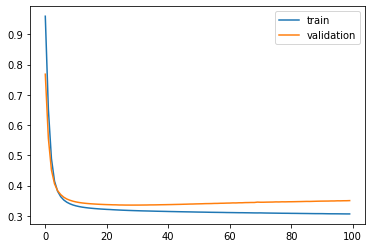

Time to train LSTM:  67.32205390930176
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 4s - loss: 1.0685 - acc: 0.5127 - val_loss: 0.9178 - val_acc: 0.6099

Epoch 00001: val_loss improved from inf to 0.91782, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.8359 - acc: 0.6772 - val_loss: 0.7546 - val_acc: 0.7230

Epoch 00002: val_loss improved from 0.91782 to 0.75464, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6925 - acc: 0.7626 - val_loss: 0.6361 - val_acc: 0.7847

Epoch 00003: val_loss improved from 0.75464 to 0.63606, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5816 - acc: 0.8116 - val_loss: 0.5424 - val_acc: 0.8230

Epoch 00004: val_loss improved from 0.63606 to 0.54241, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.4997 - acc: 0.8406 - val_loss: 0.4766 - val_acc: 0.8454

Epoch 00005: val_loss improved from 0.54241 to 0.47655, saving model to Post_val_weights1.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3140 - acc: 0.8771 - val_loss: 0.3285 - val_acc: 0.8704

Epoch 00047: val_loss did not improve from 0.32826
Epoch 48/100
 - 1s - loss: 0.3137 - acc: 0.8770 - val_loss: 0.3285 - val_acc: 0.8702

Epoch 00048: val_loss did not improve from 0.32826
Epoch 49/100
 - 1s - loss: 0.3134 - acc: 0.8772 - val_loss: 0.3287 - val_acc: 0.8699

Epoch 00049: val_loss did not improve from 0.32826
Epoch 50/100
 - 1s - loss: 0.3131 - acc: 0.8773 - val_loss: 0.3288 - val_acc: 0.8695

Epoch 00050: val_loss did not improve from 0.32826
Epoch 51/100
 - 1s - loss: 0.3128 - acc: 0.8772 - val_loss: 0.3290 - val_acc: 0.8691

Epoch 00051: val_loss did not improve from 0.32826
Epoch 52/100
 - 1s - loss: 0.3125 - acc: 0.8772 - val_loss: 0.3291 - val_acc: 0.8688

Epoch 00052: val_loss did not improve from 0.32826
Epoch 53/100
 - 1s - loss: 0.3123 - acc: 0.8773 - val_loss: 0.3293 - val_acc: 0.8683

Epoch 00053: val_loss did not improve from 0.32826
Epoch 54/100
 - 1s - loss: 0.3120 - acc: 0.8775 - val_

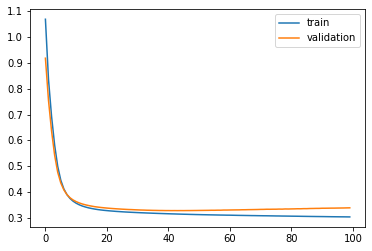

Time to train LSTM:  74.41466522216797
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 4s - loss: 1.0688 - acc: 0.5133 - val_loss: 0.9182 - val_acc: 0.6147

Epoch 00001: val_loss improved from inf to 0.91818, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.8366 - acc: 0.6758 - val_loss: 0.7522 - val_acc: 0.7384

Epoch 00002: val_loss improved from 0.91818 to 0.75218, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6941 - acc: 0.7615 - val_loss: 0.6299 - val_acc: 0.7953

Epoch 00003: val_loss improved from 0.75218 to 0.62991, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5838 - acc: 0.8099 - val_loss: 0.5343 - val_acc: 0.8318

Epoch 00004: val_loss improved from 0.62991 to 0.53425, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5013 - acc: 0.8395 - val_loss: 0.4684 - val_acc: 0.8522

Epoch 00005: val_loss improved from 0.53425 to 0.46844, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 1


Epoch 00047: val_loss did not improve from 0.33012
Epoch 48/100
 - 1s - loss: 0.3135 - acc: 0.8765 - val_loss: 0.3305 - val_acc: 0.8712

Epoch 00048: val_loss did not improve from 0.33012
Epoch 49/100
 - 1s - loss: 0.3132 - acc: 0.8765 - val_loss: 0.3308 - val_acc: 0.8705

Epoch 00049: val_loss did not improve from 0.33012
Epoch 50/100
 - 1s - loss: 0.3129 - acc: 0.8764 - val_loss: 0.3308 - val_acc: 0.8704

Epoch 00050: val_loss did not improve from 0.33012
Epoch 51/100
 - 1s - loss: 0.3127 - acc: 0.8765 - val_loss: 0.3309 - val_acc: 0.8703

Epoch 00051: val_loss did not improve from 0.33012
Epoch 52/100
 - 1s - loss: 0.3124 - acc: 0.8767 - val_loss: 0.3313 - val_acc: 0.8698

Epoch 00052: val_loss did not improve from 0.33012
Epoch 53/100
 - 1s - loss: 0.3122 - acc: 0.8768 - val_loss: 0.3311 - val_acc: 0.8697

Epoch 00053: val_loss did not improve from 0.33012
Epoch 54/100
 - 1s - loss: 0.3120 - acc: 0.8768 - val_loss: 0.3318 - val_acc: 0.8691

Epoch 00054: val_loss did not improve fr

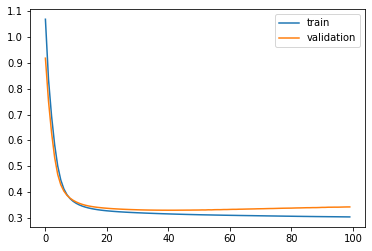

Time to train LSTM:  73.47715997695923


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f67902cbb00>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 4s - loss: 1.0680 - acc: 0.5145 - val_loss: 0.9240 - val_acc: 0.6151

Epoch 00001: val_loss improved from inf to 0.92405, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.8357 - acc: 0.6767 - val_loss: 0.7592 - val_acc: 0.7239

Epoch 00002: val_loss improved from 0.92405 to 0.75922, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6927 - acc: 0.7636 - val_loss: 0.6379 - val_acc: 0.7832

Epoch 00003: val_loss improved from 0.75922 to 0.63785, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5819 - acc: 0.8116 - val_loss: 0.5448 - val_acc: 0.8239

Epoch 00004: val_loss improved from 0.63785 to 0.54483, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4996 - acc: 0.8403 - val_loss: 0.4814 - val_acc: 0.8416

Epoch 00005: val_loss improved from 0.54483 to 0.48143, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4458 - acc: 0.8559 - val_lo

 - 1s - loss: 0.3133 - acc: 0.8767 - val_loss: 0.3363 - val_acc: 0.8674

Epoch 00047: val_loss did not improve from 0.33621
Epoch 48/100
 - 1s - loss: 0.3131 - acc: 0.8769 - val_loss: 0.3363 - val_acc: 0.8670

Epoch 00048: val_loss did not improve from 0.33621
Epoch 49/100
 - 1s - loss: 0.3127 - acc: 0.8769 - val_loss: 0.3364 - val_acc: 0.8667

Epoch 00049: val_loss did not improve from 0.33621
Epoch 50/100
 - 1s - loss: 0.3124 - acc: 0.8771 - val_loss: 0.3365 - val_acc: 0.8663

Epoch 00050: val_loss did not improve from 0.33621
Epoch 51/100
 - 1s - loss: 0.3121 - acc: 0.8772 - val_loss: 0.3365 - val_acc: 0.8658

Epoch 00051: val_loss did not improve from 0.33621
Epoch 52/100
 - 1s - loss: 0.3118 - acc: 0.8773 - val_loss: 0.3366 - val_acc: 0.8655

Epoch 00052: val_loss did not improve from 0.33621
Epoch 53/100
 - 1s - loss: 0.3115 - acc: 0.8773 - val_loss: 0.3368 - val_acc: 0.8651

Epoch 00053: val_loss did not improve from 0.33621
Epoch 54/100
 - 1s - loss: 0.3112 - acc: 0.8774 - val_

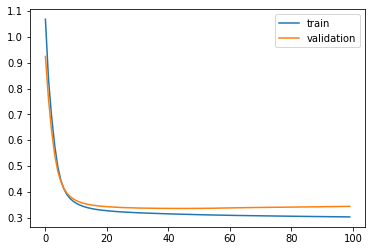

Time to train LSTM:  76.9073052406311
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 5s - loss: 1.0688 - acc: 0.5144 - val_loss: 0.9277 - val_acc: 0.6097

Epoch 00001: val_loss improved from inf to 0.92768, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.8362 - acc: 0.6748 - val_loss: 0.7628 - val_acc: 0.7202

Epoch 00002: val_loss improved from 0.92768 to 0.76276, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6932 - acc: 0.7626 - val_loss: 0.6376 - val_acc: 0.7858

Epoch 00003: val_loss improved from 0.76276 to 0.63760, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5833 - acc: 0.8110 - val_loss: 0.5396 - val_acc: 0.8270

Epoch 00004: val_loss improved from 0.63760 to 0.53960, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5014 - acc: 0.8396 - val_loss: 0.4721 - val_acc: 0.8498

Epoch 00005: val_loss improved from 0.53960 to 0.47205, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 1s

 - 1s - loss: 0.3132 - acc: 0.8762 - val_loss: 0.3303 - val_acc: 0.8719

Epoch 00048: val_loss did not improve from 0.32965
Epoch 49/100
 - 1s - loss: 0.3129 - acc: 0.8761 - val_loss: 0.3300 - val_acc: 0.8724

Epoch 00049: val_loss did not improve from 0.32965
Epoch 50/100
 - 1s - loss: 0.3127 - acc: 0.8763 - val_loss: 0.3303 - val_acc: 0.8718

Epoch 00050: val_loss did not improve from 0.32965
Epoch 51/100
 - 1s - loss: 0.3124 - acc: 0.8763 - val_loss: 0.3306 - val_acc: 0.8717

Epoch 00051: val_loss did not improve from 0.32965
Epoch 52/100
 - 1s - loss: 0.3121 - acc: 0.8763 - val_loss: 0.3307 - val_acc: 0.8709

Epoch 00052: val_loss did not improve from 0.32965
Epoch 53/100
 - 1s - loss: 0.3118 - acc: 0.8763 - val_loss: 0.3308 - val_acc: 0.8706

Epoch 00053: val_loss did not improve from 0.32965
Epoch 54/100
 - 1s - loss: 0.3115 - acc: 0.8764 - val_loss: 0.3309 - val_acc: 0.8709

Epoch 00054: val_loss did not improve from 0.32965
Epoch 55/100
 - 1s - loss: 0.3113 - acc: 0.8765 - val_

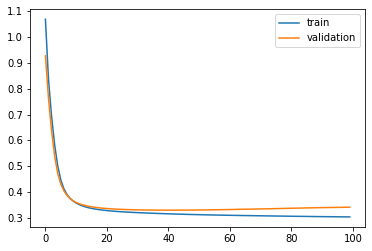

Time to train LSTM:  75.51373052597046
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 4s - loss: 1.0689 - acc: 0.5152 - val_loss: 0.9261 - val_acc: 0.6015

Epoch 00001: val_loss improved from inf to 0.92605, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.8365 - acc: 0.6737 - val_loss: 0.7578 - val_acc: 0.7270

Epoch 00002: val_loss improved from 0.92605 to 0.75783, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6927 - acc: 0.7630 - val_loss: 0.6342 - val_acc: 0.7906

Epoch 00003: val_loss improved from 0.75783 to 0.63415, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5816 - acc: 0.8121 - val_loss: 0.5403 - val_acc: 0.8232

Epoch 00004: val_loss improved from 0.63415 to 0.54030, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.4993 - acc: 0.8404 - val_loss: 0.4780 - val_acc: 0.8444

Epoch 00005: val_loss improved from 0.54030 to 0.47801, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3140 - acc: 0.8768 - val_loss: 0.3344 - val_acc: 0.8653

Epoch 00047: val_loss improved from 0.33455 to 0.33442, saving model to Post_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3137 - acc: 0.8768 - val_loss: 0.3348 - val_acc: 0.8654

Epoch 00048: val_loss did not improve from 0.33442
Epoch 49/100
 - 1s - loss: 0.3135 - acc: 0.8769 - val_loss: 0.3345 - val_acc: 0.8653

Epoch 00049: val_loss did not improve from 0.33442
Epoch 50/100
 - 1s - loss: 0.3132 - acc: 0.8769 - val_loss: 0.3347 - val_acc: 0.8648

Epoch 00050: val_loss did not improve from 0.33442
Epoch 51/100
 - 1s - loss: 0.3129 - acc: 0.8772 - val_loss: 0.3345 - val_acc: 0.8646

Epoch 00051: val_loss did not improve from 0.33442
Epoch 52/100
 - 1s - loss: 0.3126 - acc: 0.8775 - val_loss: 0.3346 - val_acc: 0.8646

Epoch 00052: val_loss did not improve from 0.33442
Epoch 53/100
 - 1s - loss: 0.3123 - acc: 0.8777 - val_loss: 0.3348 - val_acc: 0.8646

Epoch 00053: val_loss did not improve from 0.33442
Epoch 54/1

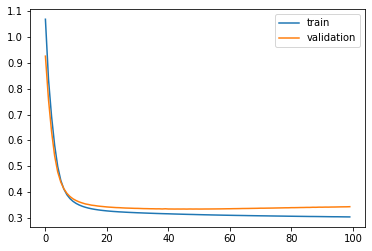

Time to train LSTM:  76.29154253005981
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 5s - loss: 1.1469 - acc: 0.4693 - val_loss: 1.0315 - val_acc: 0.5241

Epoch 00001: val_loss improved from inf to 1.03152, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.9770 - acc: 0.5660 - val_loss: 0.9036 - val_acc: 0.6199

Epoch 00002: val_loss improved from 1.03152 to 0.90358, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.8634 - acc: 0.6563 - val_loss: 0.8104 - val_acc: 0.6867

Epoch 00003: val_loss improved from 0.90358 to 0.81041, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.7764 - acc: 0.7161 - val_loss: 0.7353 - val_acc: 0.7342

Epoch 00004: val_loss improved from 0.81041 to 0.73525, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.7031 - acc: 0.7577 - val_loss: 0.6703 - val_acc: 0.7715

Epoch 00005: val_loss improved from 0.73525 to 0.67035, saving model to Post_val_weights1.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3222 - acc: 0.8753 - val_loss: 0.3347 - val_acc: 0.8694

Epoch 00046: val_loss improved from 0.33501 to 0.33470, saving model to Post_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3218 - acc: 0.8752 - val_loss: 0.3345 - val_acc: 0.8692

Epoch 00047: val_loss improved from 0.33470 to 0.33445, saving model to Post_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3214 - acc: 0.8752 - val_loss: 0.3340 - val_acc: 0.8692

Epoch 00048: val_loss improved from 0.33445 to 0.33403, saving model to Post_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3210 - acc: 0.8752 - val_loss: 0.3338 - val_acc: 0.8688

Epoch 00049: val_loss improved from 0.33403 to 0.33379, saving model to Post_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3206 - acc: 0.8753 - val_loss: 0.3335 - val_acc: 0.8687

Epoch 00050: val_loss improved from 0.33379 to 0.33346, saving model to Post_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3203 - acc: 0.8755 - val_loss: 0.3332 - val_acc: 0.8685

Epoch 00051: val_loss 


Epoch 00096: val_loss did not improve from 0.33002
Epoch 97/100
 - 1s - loss: 0.3091 - acc: 0.8782 - val_loss: 0.3311 - val_acc: 0.8668

Epoch 00097: val_loss did not improve from 0.33002
Epoch 98/100
 - 1s - loss: 0.3089 - acc: 0.8783 - val_loss: 0.3310 - val_acc: 0.8665

Epoch 00098: val_loss did not improve from 0.33002
Epoch 99/100
 - 1s - loss: 0.3087 - acc: 0.8783 - val_loss: 0.3313 - val_acc: 0.8664

Epoch 00099: val_loss did not improve from 0.33002
Epoch 100/100
 - 1s - loss: 0.3085 - acc: 0.8783 - val_loss: 0.3313 - val_acc: 0.8667

Epoch 00100: val_loss did not improve from 0.33002
#################################
Number of units: 16
Batch size: 8192
Fold: 0
best val loss: 0.3300208747317219
#################################


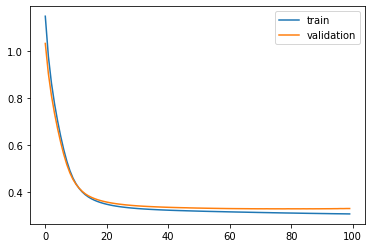

Time to train LSTM:  77.14819502830505
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 5s - loss: 1.1471 - acc: 0.4695 - val_loss: 1.0334 - val_acc: 0.5242

Epoch 00001: val_loss improved from inf to 1.03339, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.9771 - acc: 0.5663 - val_loss: 0.9039 - val_acc: 0.6276

Epoch 00002: val_loss improved from 1.03339 to 0.90389, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.8635 - acc: 0.6549 - val_loss: 0.8088 - val_acc: 0.6985

Epoch 00003: val_loss improved from 0.90389 to 0.80884, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.7764 - acc: 0.7156 - val_loss: 0.7312 - val_acc: 0.7499

Epoch 00004: val_loss improved from 0.80884 to 0.73121, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.7029 - acc: 0.7578 - val_loss: 0.6635 - val_acc: 0.7806

Epoch 00005: val_loss improved from 0.73121 to 0.66348, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3213 - acc: 0.8752 - val_loss: 0.3337 - val_acc: 0.8723

Epoch 00046: val_loss improved from 0.33402 to 0.33366, saving model to Post_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3209 - acc: 0.8752 - val_loss: 0.3334 - val_acc: 0.8722

Epoch 00047: val_loss improved from 0.33366 to 0.33339, saving model to Post_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3205 - acc: 0.8753 - val_loss: 0.3331 - val_acc: 0.8724

Epoch 00048: val_loss improved from 0.33339 to 0.33307, saving model to Post_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3201 - acc: 0.8754 - val_loss: 0.3328 - val_acc: 0.8724

Epoch 00049: val_loss improved from 0.33307 to 0.33282, saving model to Post_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3197 - acc: 0.8756 - val_loss: 0.3325 - val_acc: 0.8724

Epoch 00050: val_loss improved from 0.33282 to 0.33255, saving model to Post_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3194 - acc: 0.8758 - val_loss: 0.3323 - val_acc: 0.8724

Epoch 00051: val_loss 

 - 1s - loss: 0.3081 - acc: 0.8782 - val_loss: 0.3327 - val_acc: 0.8687

Epoch 00098: val_loss did not improve from 0.33046
Epoch 99/100
 - 1s - loss: 0.3079 - acc: 0.8782 - val_loss: 0.3329 - val_acc: 0.8682

Epoch 00099: val_loss did not improve from 0.33046
Epoch 100/100
 - 1s - loss: 0.3078 - acc: 0.8782 - val_loss: 0.3331 - val_acc: 0.8677

Epoch 00100: val_loss did not improve from 0.33046
#################################
Number of units: 16
Batch size: 8192
Fold: 1
best val loss: 0.330462209139651
#################################


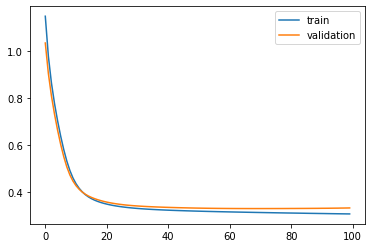

Time to train LSTM:  78.96147894859314


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f678cc60668>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 6s - loss: 1.1463 - acc: 0.4693 - val_loss: 1.0396 - val_acc: 0.5242

Epoch 00001: val_loss improved from inf to 1.03963, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.9765 - acc: 0.5661 - val_loss: 0.9095 - val_acc: 0.6249

Epoch 00002: val_loss improved from 1.03963 to 0.90946, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.8626 - acc: 0.6557 - val_loss: 0.8151 - val_acc: 0.6898

Epoch 00003: val_loss improved from 0.90946 to 0.81510, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.7754 - acc: 0.7172 - val_loss: 0.7381 - val_acc: 0.7345

Epoch 00004: val_loss improved from 0.81510 to 0.73807, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.7018 - acc: 0.7590 - val_loss: 0.6708 - val_acc: 0.7684

Epoch 00005: val_loss improved from 0.73807 to 0.67078, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.6369 - acc: 0.7878 - val_lo

 - 1s - loss: 0.3204 - acc: 0.8754 - val_loss: 0.3395 - val_acc: 0.8655

Epoch 00046: val_loss improved from 0.33968 to 0.33949, saving model to Post_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3200 - acc: 0.8756 - val_loss: 0.3393 - val_acc: 0.8655

Epoch 00047: val_loss improved from 0.33949 to 0.33927, saving model to Post_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8756 - val_loss: 0.3391 - val_acc: 0.8654

Epoch 00048: val_loss improved from 0.33927 to 0.33913, saving model to Post_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3192 - acc: 0.8756 - val_loss: 0.3389 - val_acc: 0.8656

Epoch 00049: val_loss improved from 0.33913 to 0.33893, saving model to Post_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8755 - val_loss: 0.3388 - val_acc: 0.8658

Epoch 00050: val_loss improved from 0.33893 to 0.33880, saving model to Post_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8754 - val_loss: 0.3387 - val_acc: 0.8661

Epoch 00051: val_loss 

 - 1s - loss: 0.3078 - acc: 0.8784 - val_loss: 0.3373 - val_acc: 0.8657

Epoch 00096: val_loss did not improve from 0.33601
Epoch 97/100
 - 1s - loss: 0.3076 - acc: 0.8784 - val_loss: 0.3374 - val_acc: 0.8655

Epoch 00097: val_loss did not improve from 0.33601
Epoch 98/100
 - 1s - loss: 0.3074 - acc: 0.8785 - val_loss: 0.3375 - val_acc: 0.8650

Epoch 00098: val_loss did not improve from 0.33601
Epoch 99/100
 - 1s - loss: 0.3072 - acc: 0.8785 - val_loss: 0.3377 - val_acc: 0.8648

Epoch 00099: val_loss did not improve from 0.33601
Epoch 100/100
 - 1s - loss: 0.3070 - acc: 0.8785 - val_loss: 0.3378 - val_acc: 0.8648

Epoch 00100: val_loss did not improve from 0.33601
#################################
Number of units: 16
Batch size: 8192
Fold: 2
best val loss: 0.3360145849094056
#################################


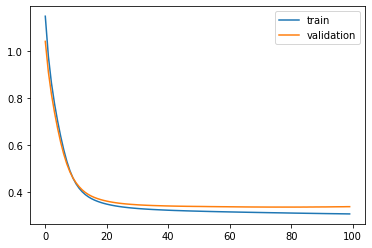

Time to train LSTM:  84.40828347206116
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 5s - loss: 1.1469 - acc: 0.4696 - val_loss: 1.0403 - val_acc: 0.5220

Epoch 00001: val_loss improved from inf to 1.04028, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.9767 - acc: 0.5665 - val_loss: 0.9130 - val_acc: 0.6200

Epoch 00002: val_loss improved from 1.04028 to 0.91305, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.8627 - acc: 0.6552 - val_loss: 0.8192 - val_acc: 0.6854

Epoch 00003: val_loss improved from 0.91305 to 0.81923, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.7753 - acc: 0.7174 - val_loss: 0.7409 - val_acc: 0.7319

Epoch 00004: val_loss improved from 0.81923 to 0.74086, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.7018 - acc: 0.7582 - val_loss: 0.6715 - val_acc: 0.7680

Epoch 00005: val_loss improved from 0.74086 to 0.67154, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3220 - acc: 0.8751 - val_loss: 0.3316 - val_acc: 0.8738

Epoch 00046: val_loss improved from 0.33179 to 0.33163, saving model to Post_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3216 - acc: 0.8751 - val_loss: 0.3312 - val_acc: 0.8737

Epoch 00047: val_loss improved from 0.33163 to 0.33124, saving model to Post_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3212 - acc: 0.8752 - val_loss: 0.3310 - val_acc: 0.8733

Epoch 00048: val_loss improved from 0.33124 to 0.33099, saving model to Post_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3208 - acc: 0.8753 - val_loss: 0.3307 - val_acc: 0.8732

Epoch 00049: val_loss improved from 0.33099 to 0.33069, saving model to Post_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3203 - acc: 0.8754 - val_loss: 0.3305 - val_acc: 0.8735

Epoch 00050: val_loss improved from 0.33069 to 0.33047, saving model to Post_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3200 - acc: 0.8754 - val_loss: 0.3302 - val_acc: 0.8733

Epoch 00051: val_loss 


Epoch 00098: val_loss did not improve from 0.32808
Epoch 99/100
 - 1s - loss: 0.3082 - acc: 0.8777 - val_loss: 0.3304 - val_acc: 0.8723

Epoch 00099: val_loss did not improve from 0.32808
Epoch 100/100
 - 1s - loss: 0.3080 - acc: 0.8777 - val_loss: 0.3306 - val_acc: 0.8722

Epoch 00100: val_loss did not improve from 0.32808
#################################
Number of units: 16
Batch size: 8192
Fold: 3
best val loss: 0.32807612699374816
#################################


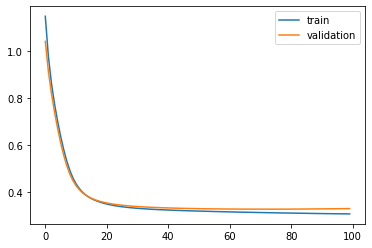

Time to train LSTM:  78.46728777885437
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 6s - loss: 1.1465 - acc: 0.4699 - val_loss: 1.0424 - val_acc: 0.5181

Epoch 00001: val_loss improved from inf to 1.04238, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.9769 - acc: 0.5661 - val_loss: 0.9108 - val_acc: 0.6122

Epoch 00002: val_loss improved from 1.04238 to 0.91081, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.8631 - acc: 0.6542 - val_loss: 0.8148 - val_acc: 0.6909

Epoch 00003: val_loss improved from 0.91081 to 0.81484, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.7757 - acc: 0.7171 - val_loss: 0.7362 - val_acc: 0.7395

Epoch 00004: val_loss improved from 0.81484 to 0.73623, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.7018 - acc: 0.7581 - val_loss: 0.6678 - val_acc: 0.7751

Epoch 00005: val_loss improved from 0.73623 to 0.66779, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3211 - acc: 0.8754 - val_loss: 0.3398 - val_acc: 0.8664

Epoch 00046: val_loss improved from 0.34004 to 0.33975, saving model to Post_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3207 - acc: 0.8754 - val_loss: 0.3396 - val_acc: 0.8664

Epoch 00047: val_loss improved from 0.33975 to 0.33958, saving model to Post_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3203 - acc: 0.8754 - val_loss: 0.3391 - val_acc: 0.8669

Epoch 00048: val_loss improved from 0.33958 to 0.33914, saving model to Post_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3200 - acc: 0.8756 - val_loss: 0.3390 - val_acc: 0.8667

Epoch 00049: val_loss improved from 0.33914 to 0.33896, saving model to Post_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3196 - acc: 0.8756 - val_loss: 0.3387 - val_acc: 0.8663

Epoch 00050: val_loss improved from 0.33896 to 0.33868, saving model to Post_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8755 - val_loss: 0.3385 - val_acc: 0.8662

Epoch 00051: val_loss 


Epoch 00097: val_loss did not improve from 0.33612
Epoch 98/100
 - 1s - loss: 0.3079 - acc: 0.8790 - val_loss: 0.3377 - val_acc: 0.8642

Epoch 00098: val_loss did not improve from 0.33612
Epoch 99/100
 - 1s - loss: 0.3077 - acc: 0.8790 - val_loss: 0.3379 - val_acc: 0.8639

Epoch 00099: val_loss did not improve from 0.33612
Epoch 100/100
 - 1s - loss: 0.3075 - acc: 0.8791 - val_loss: 0.3380 - val_acc: 0.8637

Epoch 00100: val_loss did not improve from 0.33612
#################################
Number of units: 16
Batch size: 8192
Fold: 4
best val loss: 0.33612065163969296
#################################
[[16, 512, 0, 0.33344130067797434], [16, 512, 1, 0.33365830542748437], [16, 512, 2, 0.3391906669892763], [16, 512, 3, 0.3334132865367577], [16, 512, 4, 0.3394083375122115], [16, 1024, 0, 0.3331538017172562], [16, 1024, 1, 0.33298310250566715], [16, 1024, 2, 0.3394669556757163], [16, 1024, 3, 0.33222298836847497], [16, 1024, 4, 0.33804537513102706], [16, 2048, 0, 0.32901830730382464], [

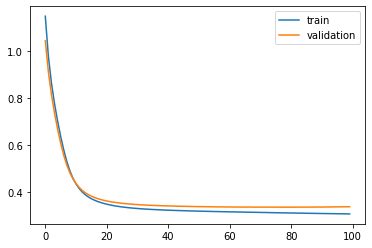

Time to train LSTM:  77.95448589324951
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 7s - loss: 0.7137 - acc: 0.8062 - val_loss: 0.4708 - val_acc: 0.8656

Epoch 00001: val_loss improved from inf to 0.47075, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.4094 - acc: 0.8687 - val_loss: 0.3839 - val_acc: 0.8703

Epoch 00002: val_loss improved from 0.47075 to 0.38387, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.3603 - acc: 0.8709 - val_loss: 0.3587 - val_acc: 0.8697

Epoch 00003: val_loss improved from 0.38387 to 0.35873, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.3437 - acc: 0.8717 - val_loss: 0.3488 - val_acc: 0.8695

Epoch 00004: val_loss improved from 0.35873 to 0.34882, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.3367 - acc: 0.8720 - val_loss: 0.3438 - val_acc: 0.8703

Epoch 00005: val_loss improved from 0.34882 to 0.34384, saving model to Post_val_weights1.hdf5
Epoch 6/100
 - 1


Epoch 00056: val_loss did not improve from 0.33564
Epoch 57/100
 - 1s - loss: 0.3141 - acc: 0.8818 - val_loss: 0.3624 - val_acc: 0.8643

Epoch 00057: val_loss did not improve from 0.33564
Epoch 58/100
 - 1s - loss: 0.3141 - acc: 0.8821 - val_loss: 0.3616 - val_acc: 0.8630

Epoch 00058: val_loss did not improve from 0.33564
Epoch 59/100
 - 1s - loss: 0.3135 - acc: 0.8824 - val_loss: 0.3627 - val_acc: 0.8653

Epoch 00059: val_loss did not improve from 0.33564
Epoch 60/100
 - 1s - loss: 0.3138 - acc: 0.8830 - val_loss: 0.3631 - val_acc: 0.8647

Epoch 00060: val_loss did not improve from 0.33564
Epoch 61/100
 - 1s - loss: 0.3135 - acc: 0.8830 - val_loss: 0.3654 - val_acc: 0.8628

Epoch 00061: val_loss did not improve from 0.33564
Epoch 62/100
 - 1s - loss: 0.3136 - acc: 0.8831 - val_loss: 0.3653 - val_acc: 0.8656

Epoch 00062: val_loss did not improve from 0.33564
Epoch 63/100
 - 1s - loss: 0.3133 - acc: 0.8833 - val_loss: 0.3681 - val_acc: 0.8647

Epoch 00063: val_loss did not improve fr

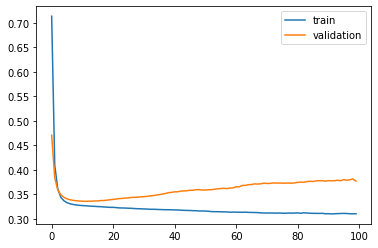

Time to train LSTM:  152.0707983970642
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 7s - loss: 0.7109 - acc: 0.8078 - val_loss: 0.4653 - val_acc: 0.8649

Epoch 00001: val_loss improved from inf to 0.46533, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.4089 - acc: 0.8691 - val_loss: 0.3780 - val_acc: 0.8689

Epoch 00002: val_loss improved from 0.46533 to 0.37805, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.3597 - acc: 0.8710 - val_loss: 0.3536 - val_acc: 0.8701

Epoch 00003: val_loss improved from 0.37805 to 0.35359, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.3436 - acc: 0.8719 - val_loss: 0.3442 - val_acc: 0.8705

Epoch 00004: val_loss improved from 0.35359 to 0.34419, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.3366 - acc: 0.8722 - val_loss: 0.3398 - val_acc: 0.8705

Epoch 00005: val_loss improved from 0.34419 to 0.33985, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3140 - acc: 0.8822 - val_loss: 0.3647 - val_acc: 0.8646

Epoch 00058: val_loss did not improve from 0.33624
Epoch 59/100
 - 1s - loss: 0.3136 - acc: 0.8823 - val_loss: 0.3643 - val_acc: 0.8657

Epoch 00059: val_loss did not improve from 0.33624
Epoch 60/100
 - 1s - loss: 0.3134 - acc: 0.8825 - val_loss: 0.3655 - val_acc: 0.8655

Epoch 00060: val_loss did not improve from 0.33624
Epoch 61/100
 - 1s - loss: 0.3134 - acc: 0.8822 - val_loss: 0.3641 - val_acc: 0.8656

Epoch 00061: val_loss did not improve from 0.33624
Epoch 62/100
 - 1s - loss: 0.3130 - acc: 0.8828 - val_loss: 0.3661 - val_acc: 0.8640

Epoch 00062: val_loss did not improve from 0.33624
Epoch 63/100
 - 1s - loss: 0.3128 - acc: 0.8827 - val_loss: 0.3679 - val_acc: 0.8630

Epoch 00063: val_loss did not improve from 0.33624
Epoch 64/100
 - 1s - loss: 0.3125 - acc: 0.8827 - val_loss: 0.3683 - val_acc: 0.8623

Epoch 00064: val_loss did not improve from 0.33624
Epoch 65/100
 - 1s - loss: 0.3125 - acc: 0.8828 - val_

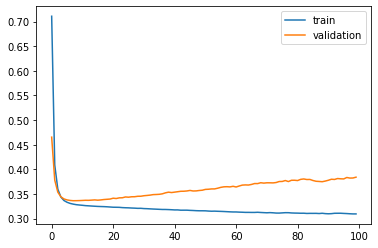

Time to train LSTM:  152.6981680393219
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 7s - loss: 0.7094 - acc: 0.8090 - val_loss: 0.4712 - val_acc: 0.8598

Epoch 00001: val_loss improved from inf to 0.47124, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.4080 - acc: 0.8692 - val_loss: 0.3828 - val_acc: 0.8643

Epoch 00002: val_loss improved from 0.47124 to 0.38277, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.3587 - acc: 0.8718 - val_loss: 0.3586 - val_acc: 0.8646

Epoch 00003: val_loss improved from 0.38277 to 0.35856, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.3428 - acc: 0.8723 - val_loss: 0.3491 - val_acc: 0.8642

Epoch 00004: val_loss improved from 0.35856 to 0.34907, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.3358 - acc: 0.8725 - val_loss: 0.3447 - val_acc: 0.8644

Epoch 00005: val_loss improved from 0.34907 to 0.34470, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3131 - acc: 0.8831 - val_loss: 0.3675 - val_acc: 0.8595

Epoch 00057: val_loss did not improve from 0.34011
Epoch 58/100
 - 1s - loss: 0.3128 - acc: 0.8833 - val_loss: 0.3681 - val_acc: 0.8596

Epoch 00058: val_loss did not improve from 0.34011
Epoch 59/100
 - 1s - loss: 0.3127 - acc: 0.8834 - val_loss: 0.3708 - val_acc: 0.8582

Epoch 00059: val_loss did not improve from 0.34011
Epoch 60/100
 - 1s - loss: 0.3123 - acc: 0.8838 - val_loss: 0.3716 - val_acc: 0.8575

Epoch 00060: val_loss did not improve from 0.34011
Epoch 61/100
 - 1s - loss: 0.3126 - acc: 0.8834 - val_loss: 0.3727 - val_acc: 0.8582

Epoch 00061: val_loss did not improve from 0.34011
Epoch 62/100
 - 1s - loss: 0.3127 - acc: 0.8829 - val_loss: 0.3736 - val_acc: 0.8575

Epoch 00062: val_loss did not improve from 0.34011
Epoch 63/100
 - 1s - loss: 0.3125 - acc: 0.8834 - val_loss: 0.3725 - val_acc: 0.8567

Epoch 00063: val_loss did not improve from 0.34011
Epoch 64/100
 - 1s - loss: 0.3129 - acc: 0.8833 - val_

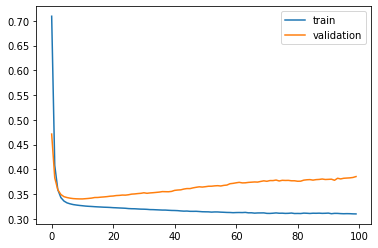

Time to train LSTM:  153.12201070785522


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f676d3c2fd0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 7s - loss: 0.7101 - acc: 0.8075 - val_loss: 0.4658 - val_acc: 0.8677

Epoch 00001: val_loss improved from inf to 0.46579, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.4084 - acc: 0.8689 - val_loss: 0.3773 - val_acc: 0.8702

Epoch 00002: val_loss improved from 0.46579 to 0.37732, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.3594 - acc: 0.8710 - val_loss: 0.3516 - val_acc: 0.8713

Epoch 00003: val_loss improved from 0.37732 to 0.35159, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.3433 - acc: 0.8714 - val_loss: 0.3421 - val_acc: 0.8722

Epoch 00004: val_loss improved from 0.35159 to 0.34211, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.3365 - acc: 0.8715 - val_loss: 0.3379 - val_acc: 0.8722

Epoch 00005: val_loss improved from 0.34211 to 0.33792, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.3329 - acc: 0.8719 - val_lo


Epoch 00058: val_loss did not improve from 0.33541
Epoch 59/100
 - 1s - loss: 0.3150 - acc: 0.8810 - val_loss: 0.3657 - val_acc: 0.8636

Epoch 00059: val_loss did not improve from 0.33541
Epoch 60/100
 - 1s - loss: 0.3144 - acc: 0.8807 - val_loss: 0.3665 - val_acc: 0.8627

Epoch 00060: val_loss did not improve from 0.33541
Epoch 61/100
 - 1s - loss: 0.3143 - acc: 0.8805 - val_loss: 0.3662 - val_acc: 0.8620

Epoch 00061: val_loss did not improve from 0.33541
Epoch 62/100
 - 1s - loss: 0.3142 - acc: 0.8808 - val_loss: 0.3671 - val_acc: 0.8619

Epoch 00062: val_loss did not improve from 0.33541
Epoch 63/100
 - 1s - loss: 0.3143 - acc: 0.8813 - val_loss: 0.3677 - val_acc: 0.8637

Epoch 00063: val_loss did not improve from 0.33541
Epoch 64/100
 - 1s - loss: 0.3140 - acc: 0.8812 - val_loss: 0.3682 - val_acc: 0.8630

Epoch 00064: val_loss did not improve from 0.33541
Epoch 65/100
 - 1s - loss: 0.3134 - acc: 0.8813 - val_loss: 0.3719 - val_acc: 0.8615

Epoch 00065: val_loss did not improve fr

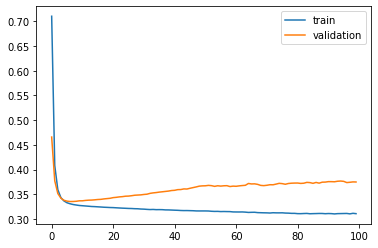

Time to train LSTM:  153.95717525482178
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 8s - loss: 0.7131 - acc: 0.8072 - val_loss: 0.4759 - val_acc: 0.8604

Epoch 00001: val_loss improved from inf to 0.47595, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 2s - loss: 0.4077 - acc: 0.8695 - val_loss: 0.3855 - val_acc: 0.8648

Epoch 00002: val_loss improved from 0.47595 to 0.38547, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.3583 - acc: 0.8718 - val_loss: 0.3609 - val_acc: 0.8654

Epoch 00003: val_loss improved from 0.38547 to 0.36094, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.3422 - acc: 0.8724 - val_loss: 0.3515 - val_acc: 0.8654

Epoch 00004: val_loss improved from 0.36094 to 0.35152, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.3354 - acc: 0.8728 - val_loss: 0.3471 - val_acc: 0.8661

Epoch 00005: val_loss improved from 0.35152 to 0.34713, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 


Epoch 00057: val_loss did not improve from 0.34294
Epoch 58/100
 - 1s - loss: 0.3136 - acc: 0.8812 - val_loss: 0.3712 - val_acc: 0.8550

Epoch 00058: val_loss did not improve from 0.34294
Epoch 59/100
 - 1s - loss: 0.3136 - acc: 0.8817 - val_loss: 0.3726 - val_acc: 0.8530

Epoch 00059: val_loss did not improve from 0.34294
Epoch 60/100
 - 1s - loss: 0.3131 - acc: 0.8819 - val_loss: 0.3716 - val_acc: 0.8538

Epoch 00060: val_loss did not improve from 0.34294
Epoch 61/100
 - 1s - loss: 0.3130 - acc: 0.8819 - val_loss: 0.3709 - val_acc: 0.8533

Epoch 00061: val_loss did not improve from 0.34294
Epoch 62/100
 - 2s - loss: 0.3128 - acc: 0.8824 - val_loss: 0.3714 - val_acc: 0.8545

Epoch 00062: val_loss did not improve from 0.34294
Epoch 63/100
 - 1s - loss: 0.3127 - acc: 0.8820 - val_loss: 0.3714 - val_acc: 0.8546

Epoch 00063: val_loss did not improve from 0.34294
Epoch 64/100
 - 1s - loss: 0.3124 - acc: 0.8825 - val_loss: 0.3706 - val_acc: 0.8572

Epoch 00064: val_loss did not improve fr

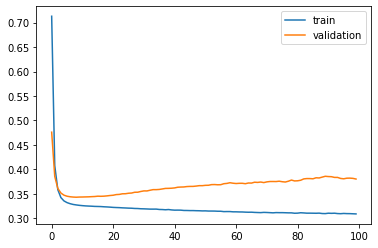

Time to train LSTM:  155.92205452919006
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 7s - loss: 0.8699 - acc: 0.7613 - val_loss: 0.6010 - val_acc: 0.8501

Epoch 00001: val_loss improved from inf to 0.60104, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.4990 - acc: 0.8636 - val_loss: 0.4431 - val_acc: 0.8670

Epoch 00002: val_loss improved from 0.60104 to 0.44311, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.4033 - acc: 0.8704 - val_loss: 0.3895 - val_acc: 0.8704

Epoch 00003: val_loss improved from 0.44311 to 0.38952, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.3671 - acc: 0.8718 - val_loss: 0.3660 - val_acc: 0.8710

Epoch 00004: val_loss improved from 0.38952 to 0.36596, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.3501 - acc: 0.8722 - val_loss: 0.3539 - val_acc: 0.8715

Epoch 00005: val_loss improved from 0.36596 to 0.35390, saving model to Post_val_weights1.hdf5
Epoch 6/100
 - 


Epoch 00056: val_loss did not improve from 0.33812
Epoch 57/100
 - 1s - loss: 0.3080 - acc: 0.8840 - val_loss: 0.3609 - val_acc: 0.8648

Epoch 00057: val_loss did not improve from 0.33812
Epoch 58/100
 - 1s - loss: 0.3076 - acc: 0.8844 - val_loss: 0.3625 - val_acc: 0.8647

Epoch 00058: val_loss did not improve from 0.33812
Epoch 59/100
 - 1s - loss: 0.3076 - acc: 0.8844 - val_loss: 0.3628 - val_acc: 0.8653

Epoch 00059: val_loss did not improve from 0.33812
Epoch 60/100
 - 1s - loss: 0.3072 - acc: 0.8847 - val_loss: 0.3633 - val_acc: 0.8654

Epoch 00060: val_loss did not improve from 0.33812
Epoch 61/100
 - 1s - loss: 0.3066 - acc: 0.8848 - val_loss: 0.3638 - val_acc: 0.8641

Epoch 00061: val_loss did not improve from 0.33812
Epoch 62/100
 - 1s - loss: 0.3063 - acc: 0.8851 - val_loss: 0.3652 - val_acc: 0.8643

Epoch 00062: val_loss did not improve from 0.33812
Epoch 63/100
 - 1s - loss: 0.3061 - acc: 0.8851 - val_loss: 0.3662 - val_acc: 0.8647

Epoch 00063: val_loss did not improve fr

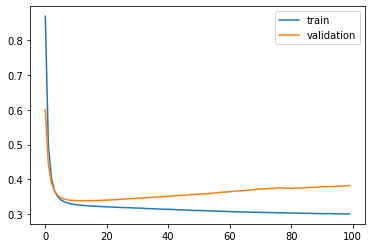

Time to train LSTM:  100.947909116745
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 8s - loss: 0.8674 - acc: 0.7634 - val_loss: 0.5934 - val_acc: 0.8543

Epoch 00001: val_loss improved from inf to 0.59336, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.4976 - acc: 0.8646 - val_loss: 0.4384 - val_acc: 0.8687

Epoch 00002: val_loss improved from 0.59336 to 0.43842, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.4026 - acc: 0.8706 - val_loss: 0.3868 - val_acc: 0.8704

Epoch 00003: val_loss improved from 0.43842 to 0.38679, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.3666 - acc: 0.8720 - val_loss: 0.3641 - val_acc: 0.8699

Epoch 00004: val_loss improved from 0.38679 to 0.36415, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.3497 - acc: 0.8725 - val_loss: 0.3523 - val_acc: 0.8704

Epoch 00005: val_loss improved from 0.36415 to 0.35232, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 1s

 - 1s - loss: 0.3082 - acc: 0.8848 - val_loss: 0.3699 - val_acc: 0.8608

Epoch 00057: val_loss did not improve from 0.33694
Epoch 58/100
 - 1s - loss: 0.3078 - acc: 0.8851 - val_loss: 0.3703 - val_acc: 0.8605

Epoch 00058: val_loss did not improve from 0.33694
Epoch 59/100
 - 1s - loss: 0.3075 - acc: 0.8851 - val_loss: 0.3705 - val_acc: 0.8604

Epoch 00059: val_loss did not improve from 0.33694
Epoch 60/100
 - 1s - loss: 0.3072 - acc: 0.8851 - val_loss: 0.3703 - val_acc: 0.8608

Epoch 00060: val_loss did not improve from 0.33694
Epoch 61/100
 - 1s - loss: 0.3072 - acc: 0.8850 - val_loss: 0.3709 - val_acc: 0.8606

Epoch 00061: val_loss did not improve from 0.33694
Epoch 62/100
 - 1s - loss: 0.3073 - acc: 0.8854 - val_loss: 0.3713 - val_acc: 0.8600

Epoch 00062: val_loss did not improve from 0.33694
Epoch 63/100
 - 1s - loss: 0.3070 - acc: 0.8850 - val_loss: 0.3716 - val_acc: 0.8591

Epoch 00063: val_loss did not improve from 0.33694
Epoch 64/100
 - 1s - loss: 0.3069 - acc: 0.8848 - val_

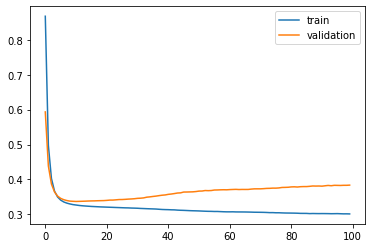

Time to train LSTM:  99.94092965126038
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 8s - loss: 0.8644 - acc: 0.7648 - val_loss: 0.5999 - val_acc: 0.8469

Epoch 00001: val_loss improved from inf to 0.59993, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.4960 - acc: 0.8654 - val_loss: 0.4426 - val_acc: 0.8593

Epoch 00002: val_loss improved from 0.59993 to 0.44263, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.4018 - acc: 0.8709 - val_loss: 0.3903 - val_acc: 0.8628

Epoch 00003: val_loss improved from 0.44263 to 0.39027, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.3656 - acc: 0.8724 - val_loss: 0.3680 - val_acc: 0.8630

Epoch 00004: val_loss improved from 0.39027 to 0.36798, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.3488 - acc: 0.8730 - val_loss: 0.3570 - val_acc: 0.8647

Epoch 00005: val_loss improved from 0.36798 to 0.35695, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3085 - acc: 0.8840 - val_loss: 0.3727 - val_acc: 0.8591

Epoch 00056: val_loss did not improve from 0.34131
Epoch 57/100
 - 1s - loss: 0.3082 - acc: 0.8840 - val_loss: 0.3737 - val_acc: 0.8595

Epoch 00057: val_loss did not improve from 0.34131
Epoch 58/100
 - 1s - loss: 0.3081 - acc: 0.8838 - val_loss: 0.3739 - val_acc: 0.8600

Epoch 00058: val_loss did not improve from 0.34131
Epoch 59/100
 - 1s - loss: 0.3078 - acc: 0.8840 - val_loss: 0.3752 - val_acc: 0.8594

Epoch 00059: val_loss did not improve from 0.34131
Epoch 60/100
 - 1s - loss: 0.3079 - acc: 0.8841 - val_loss: 0.3749 - val_acc: 0.8611

Epoch 00060: val_loss did not improve from 0.34131
Epoch 61/100
 - 1s - loss: 0.3075 - acc: 0.8843 - val_loss: 0.3756 - val_acc: 0.8598

Epoch 00061: val_loss did not improve from 0.34131
Epoch 62/100
 - 1s - loss: 0.3071 - acc: 0.8842 - val_loss: 0.3764 - val_acc: 0.8593

Epoch 00062: val_loss did not improve from 0.34131
Epoch 63/100
 - 1s - loss: 0.3072 - acc: 0.8845 - val_

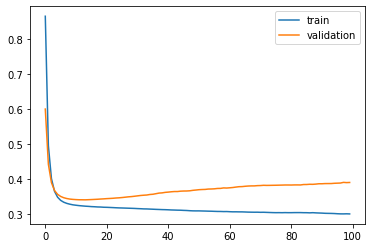

Time to train LSTM:  102.30775237083435
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 8s - loss: 0.8653 - acc: 0.7652 - val_loss: 0.5899 - val_acc: 0.8584

Epoch 00001: val_loss improved from inf to 0.58994, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.4953 - acc: 0.8646 - val_loss: 0.4362 - val_acc: 0.8689

Epoch 00002: val_loss improved from 0.58994 to 0.43622, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.4016 - acc: 0.8704 - val_loss: 0.3836 - val_acc: 0.8709

Epoch 00003: val_loss improved from 0.43622 to 0.38356, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.3657 - acc: 0.8718 - val_loss: 0.3610 - val_acc: 0.8709

Epoch 00004: val_loss improved from 0.38356 to 0.36097, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.3490 - acc: 0.8723 - val_loss: 0.3499 - val_acc: 0.8709

Epoch 00005: val_loss improved from 0.36097 to 0.34990, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 


Epoch 00056: val_loss did not improve from 0.33598
Epoch 57/100
 - 1s - loss: 0.3060 - acc: 0.8838 - val_loss: 0.3683 - val_acc: 0.8613

Epoch 00057: val_loss did not improve from 0.33598
Epoch 58/100
 - 1s - loss: 0.3058 - acc: 0.8840 - val_loss: 0.3698 - val_acc: 0.8620

Epoch 00058: val_loss did not improve from 0.33598
Epoch 59/100
 - 1s - loss: 0.3054 - acc: 0.8841 - val_loss: 0.3698 - val_acc: 0.8612

Epoch 00059: val_loss did not improve from 0.33598
Epoch 60/100
 - 1s - loss: 0.3048 - acc: 0.8843 - val_loss: 0.3708 - val_acc: 0.8614

Epoch 00060: val_loss did not improve from 0.33598
Epoch 61/100
 - 1s - loss: 0.3045 - acc: 0.8845 - val_loss: 0.3714 - val_acc: 0.8607

Epoch 00061: val_loss did not improve from 0.33598
Epoch 62/100
 - 1s - loss: 0.3041 - acc: 0.8847 - val_loss: 0.3713 - val_acc: 0.8607

Epoch 00062: val_loss did not improve from 0.33598
Epoch 63/100
 - 1s - loss: 0.3039 - acc: 0.8851 - val_loss: 0.3720 - val_acc: 0.8614

Epoch 00063: val_loss did not improve fr

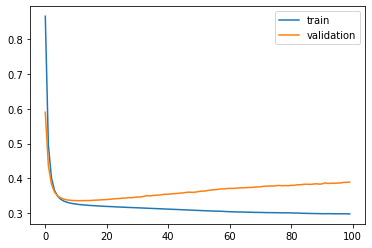

Time to train LSTM:  101.13243103027344
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 8s - loss: 0.8703 - acc: 0.7615 - val_loss: 0.6045 - val_acc: 0.8476

Epoch 00001: val_loss improved from inf to 0.60445, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.4963 - acc: 0.8644 - val_loss: 0.4448 - val_acc: 0.8635

Epoch 00002: val_loss improved from 0.60445 to 0.44476, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.4017 - acc: 0.8707 - val_loss: 0.3911 - val_acc: 0.8653

Epoch 00003: val_loss improved from 0.44476 to 0.39112, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.3655 - acc: 0.8725 - val_loss: 0.3683 - val_acc: 0.8653

Epoch 00004: val_loss improved from 0.39112 to 0.36832, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.3487 - acc: 0.8731 - val_loss: 0.3572 - val_acc: 0.8648

Epoch 00005: val_loss improved from 0.36832 to 0.35725, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 


Epoch 00055: val_loss did not improve from 0.34110
Epoch 56/100
 - 1s - loss: 0.3087 - acc: 0.8827 - val_loss: 0.3640 - val_acc: 0.8592

Epoch 00056: val_loss did not improve from 0.34110
Epoch 57/100
 - 1s - loss: 0.3086 - acc: 0.8829 - val_loss: 0.3644 - val_acc: 0.8586

Epoch 00057: val_loss did not improve from 0.34110
Epoch 58/100
 - 1s - loss: 0.3082 - acc: 0.8832 - val_loss: 0.3644 - val_acc: 0.8587

Epoch 00058: val_loss did not improve from 0.34110
Epoch 59/100
 - 1s - loss: 0.3082 - acc: 0.8832 - val_loss: 0.3653 - val_acc: 0.8591

Epoch 00059: val_loss did not improve from 0.34110
Epoch 60/100
 - 1s - loss: 0.3082 - acc: 0.8836 - val_loss: 0.3659 - val_acc: 0.8584

Epoch 00060: val_loss did not improve from 0.34110
Epoch 61/100
 - 1s - loss: 0.3075 - acc: 0.8840 - val_loss: 0.3666 - val_acc: 0.8587

Epoch 00061: val_loss did not improve from 0.34110
Epoch 62/100
 - 1s - loss: 0.3073 - acc: 0.8840 - val_loss: 0.3672 - val_acc: 0.8579

Epoch 00062: val_loss did not improve fr

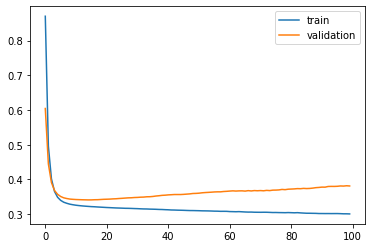

Time to train LSTM:  101.99078917503357


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f6754d46278>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 9s - loss: 1.0274 - acc: 0.7004 - val_loss: 0.8006 - val_acc: 0.7991

Epoch 00001: val_loss improved from inf to 0.80061, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6694 - acc: 0.8345 - val_loss: 0.5716 - val_acc: 0.8517

Epoch 00002: val_loss improved from 0.80061 to 0.57162, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5086 - acc: 0.8637 - val_loss: 0.4674 - val_acc: 0.8665

Epoch 00003: val_loss improved from 0.57162 to 0.46744, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.4338 - acc: 0.8688 - val_loss: 0.4153 - val_acc: 0.8690

Epoch 00004: val_loss improved from 0.46744 to 0.41526, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.3938 - acc: 0.8716 - val_loss: 0.3858 - val_acc: 0.8723

Epoch 00005: val_loss improved from 0.41526 to 0.38582, saving model to Post_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.3707 - acc: 0.8722 - val_lo

 - 1s - loss: 0.3042 - acc: 0.8829 - val_loss: 0.3565 - val_acc: 0.8664

Epoch 00055: val_loss did not improve from 0.33388
Epoch 56/100
 - 1s - loss: 0.3037 - acc: 0.8828 - val_loss: 0.3569 - val_acc: 0.8651

Epoch 00056: val_loss did not improve from 0.33388
Epoch 57/100
 - 1s - loss: 0.3031 - acc: 0.8830 - val_loss: 0.3574 - val_acc: 0.8656

Epoch 00057: val_loss did not improve from 0.33388
Epoch 58/100
 - 1s - loss: 0.3028 - acc: 0.8831 - val_loss: 0.3580 - val_acc: 0.8648

Epoch 00058: val_loss did not improve from 0.33388
Epoch 59/100
 - 1s - loss: 0.3024 - acc: 0.8834 - val_loss: 0.3592 - val_acc: 0.8642

Epoch 00059: val_loss did not improve from 0.33388
Epoch 60/100
 - 1s - loss: 0.3020 - acc: 0.8835 - val_loss: 0.3600 - val_acc: 0.8621

Epoch 00060: val_loss did not improve from 0.33388
Epoch 61/100
 - 1s - loss: 0.3013 - acc: 0.8838 - val_loss: 0.3603 - val_acc: 0.8627

Epoch 00061: val_loss did not improve from 0.33388
Epoch 62/100
 - 1s - loss: 0.3009 - acc: 0.8838 - val_

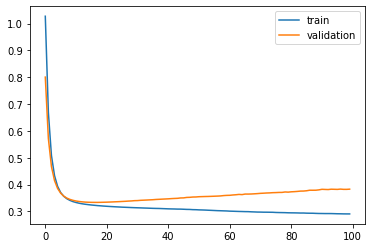

Time to train LSTM:  85.54248547554016
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 9s - loss: 1.0252 - acc: 0.7028 - val_loss: 0.7901 - val_acc: 0.8009

Epoch 00001: val_loss improved from inf to 0.79006, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6664 - acc: 0.8365 - val_loss: 0.5661 - val_acc: 0.8593

Epoch 00002: val_loss improved from 0.79006 to 0.56610, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5069 - acc: 0.8640 - val_loss: 0.4658 - val_acc: 0.8663

Epoch 00003: val_loss improved from 0.56610 to 0.46579, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.4330 - acc: 0.8691 - val_loss: 0.4151 - val_acc: 0.8698

Epoch 00004: val_loss improved from 0.46579 to 0.41512, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.3932 - acc: 0.8714 - val_loss: 0.3867 - val_acc: 0.8720

Epoch 00005: val_loss improved from 0.41512 to 0.38669, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3033 - acc: 0.8844 - val_loss: 0.3670 - val_acc: 0.8616

Epoch 00055: val_loss did not improve from 0.33498
Epoch 56/100
 - 1s - loss: 0.3030 - acc: 0.8844 - val_loss: 0.3671 - val_acc: 0.8613

Epoch 00056: val_loss did not improve from 0.33498
Epoch 57/100
 - 1s - loss: 0.3027 - acc: 0.8846 - val_loss: 0.3686 - val_acc: 0.8621

Epoch 00057: val_loss did not improve from 0.33498
Epoch 58/100
 - 1s - loss: 0.3023 - acc: 0.8851 - val_loss: 0.3691 - val_acc: 0.8619

Epoch 00058: val_loss did not improve from 0.33498
Epoch 59/100
 - 1s - loss: 0.3019 - acc: 0.8855 - val_loss: 0.3707 - val_acc: 0.8612

Epoch 00059: val_loss did not improve from 0.33498
Epoch 60/100
 - 1s - loss: 0.3017 - acc: 0.8857 - val_loss: 0.3709 - val_acc: 0.8611

Epoch 00060: val_loss did not improve from 0.33498
Epoch 61/100
 - 1s - loss: 0.3014 - acc: 0.8860 - val_loss: 0.3718 - val_acc: 0.8618

Epoch 00061: val_loss did not improve from 0.33498
Epoch 62/100
 - 1s - loss: 0.3012 - acc: 0.8863 - val_

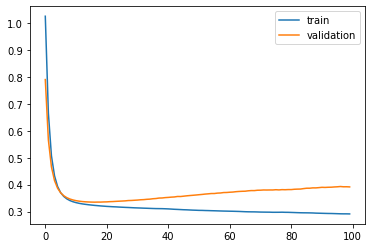

Time to train LSTM:  86.52636194229126
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 9s - loss: 1.0229 - acc: 0.7032 - val_loss: 0.7978 - val_acc: 0.7963

Epoch 00001: val_loss improved from inf to 0.79784, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6647 - acc: 0.8378 - val_loss: 0.5744 - val_acc: 0.8504

Epoch 00002: val_loss improved from 0.79784 to 0.57435, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5050 - acc: 0.8653 - val_loss: 0.4722 - val_acc: 0.8602

Epoch 00003: val_loss improved from 0.57435 to 0.47217, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.4316 - acc: 0.8700 - val_loss: 0.4207 - val_acc: 0.8630

Epoch 00004: val_loss improved from 0.47217 to 0.42072, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.3918 - acc: 0.8717 - val_loss: 0.3919 - val_acc: 0.8642

Epoch 00005: val_loss improved from 0.42072 to 0.39193, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 1


Epoch 00054: val_loss did not improve from 0.34100
Epoch 55/100
 - 1s - loss: 0.3023 - acc: 0.8849 - val_loss: 0.3722 - val_acc: 0.8575

Epoch 00055: val_loss did not improve from 0.34100
Epoch 56/100
 - 1s - loss: 0.3020 - acc: 0.8850 - val_loss: 0.3728 - val_acc: 0.8579

Epoch 00056: val_loss did not improve from 0.34100
Epoch 57/100
 - 1s - loss: 0.3015 - acc: 0.8855 - val_loss: 0.3740 - val_acc: 0.8575

Epoch 00057: val_loss did not improve from 0.34100
Epoch 58/100
 - 1s - loss: 0.3015 - acc: 0.8855 - val_loss: 0.3753 - val_acc: 0.8577

Epoch 00058: val_loss did not improve from 0.34100
Epoch 59/100
 - 1s - loss: 0.3010 - acc: 0.8856 - val_loss: 0.3766 - val_acc: 0.8574

Epoch 00059: val_loss did not improve from 0.34100
Epoch 60/100
 - 1s - loss: 0.3007 - acc: 0.8857 - val_loss: 0.3774 - val_acc: 0.8565

Epoch 00060: val_loss did not improve from 0.34100
Epoch 61/100
 - 1s - loss: 0.3004 - acc: 0.8856 - val_loss: 0.3781 - val_acc: 0.8574

Epoch 00061: val_loss did not improve fr

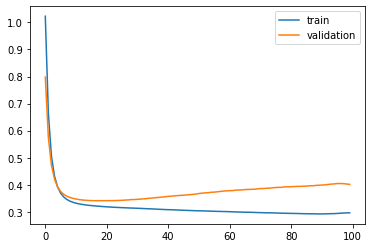

Time to train LSTM:  87.24475479125977
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 9s - loss: 1.0255 - acc: 0.7008 - val_loss: 0.7987 - val_acc: 0.7950

Epoch 00001: val_loss improved from inf to 0.79867, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6654 - acc: 0.8376 - val_loss: 0.5642 - val_acc: 0.8601

Epoch 00002: val_loss improved from 0.79867 to 0.56417, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5056 - acc: 0.8640 - val_loss: 0.4649 - val_acc: 0.8669

Epoch 00003: val_loss improved from 0.56417 to 0.46492, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.4323 - acc: 0.8696 - val_loss: 0.4132 - val_acc: 0.8705

Epoch 00004: val_loss improved from 0.46492 to 0.41324, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.3923 - acc: 0.8711 - val_loss: 0.3838 - val_acc: 0.8723

Epoch 00005: val_loss improved from 0.41324 to 0.38379, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3028 - acc: 0.8842 - val_loss: 0.3651 - val_acc: 0.8615

Epoch 00055: val_loss did not improve from 0.33379
Epoch 56/100
 - 1s - loss: 0.3023 - acc: 0.8841 - val_loss: 0.3672 - val_acc: 0.8622

Epoch 00056: val_loss did not improve from 0.33379
Epoch 57/100
 - 1s - loss: 0.3020 - acc: 0.8846 - val_loss: 0.3672 - val_acc: 0.8614

Epoch 00057: val_loss did not improve from 0.33379
Epoch 58/100
 - 1s - loss: 0.3017 - acc: 0.8847 - val_loss: 0.3677 - val_acc: 0.8608

Epoch 00058: val_loss did not improve from 0.33379
Epoch 59/100
 - 1s - loss: 0.3012 - acc: 0.8848 - val_loss: 0.3683 - val_acc: 0.8604

Epoch 00059: val_loss did not improve from 0.33379
Epoch 60/100
 - 1s - loss: 0.3009 - acc: 0.8851 - val_loss: 0.3697 - val_acc: 0.8606

Epoch 00060: val_loss did not improve from 0.33379
Epoch 61/100
 - 1s - loss: 0.3006 - acc: 0.8851 - val_loss: 0.3693 - val_acc: 0.8608

Epoch 00061: val_loss did not improve from 0.33379
Epoch 62/100
 - 1s - loss: 0.3002 - acc: 0.8850 - val_

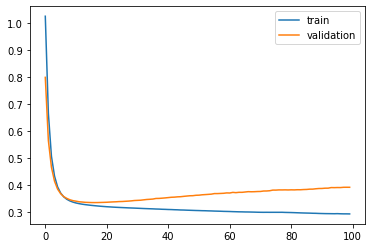

Time to train LSTM:  73.45234084129333
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 10s - loss: 1.0293 - acc: 0.6987 - val_loss: 0.8072 - val_acc: 0.7944

Epoch 00001: val_loss improved from inf to 0.80717, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6675 - acc: 0.8379 - val_loss: 0.5771 - val_acc: 0.8523

Epoch 00002: val_loss improved from 0.80717 to 0.57709, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5063 - acc: 0.8644 - val_loss: 0.4756 - val_acc: 0.8613

Epoch 00003: val_loss improved from 0.57709 to 0.47564, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.4323 - acc: 0.8699 - val_loss: 0.4229 - val_acc: 0.8643

Epoch 00004: val_loss improved from 0.47564 to 0.42291, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.3919 - acc: 0.8722 - val_loss: 0.3929 - val_acc: 0.8640

Epoch 00005: val_loss improved from 0.42291 to 0.39292, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 


Epoch 00054: val_loss did not improve from 0.34033
Epoch 55/100
 - 1s - loss: 0.3031 - acc: 0.8834 - val_loss: 0.3648 - val_acc: 0.8592

Epoch 00055: val_loss did not improve from 0.34033
Epoch 56/100
 - 1s - loss: 0.3028 - acc: 0.8833 - val_loss: 0.3659 - val_acc: 0.8592

Epoch 00056: val_loss did not improve from 0.34033
Epoch 57/100
 - 1s - loss: 0.3025 - acc: 0.8838 - val_loss: 0.3672 - val_acc: 0.8580

Epoch 00057: val_loss did not improve from 0.34033
Epoch 58/100
 - 1s - loss: 0.3024 - acc: 0.8839 - val_loss: 0.3687 - val_acc: 0.8585

Epoch 00058: val_loss did not improve from 0.34033
Epoch 59/100
 - 1s - loss: 0.3022 - acc: 0.8841 - val_loss: 0.3694 - val_acc: 0.8578

Epoch 00059: val_loss did not improve from 0.34033
Epoch 60/100
 - 1s - loss: 0.3021 - acc: 0.8841 - val_loss: 0.3704 - val_acc: 0.8584

Epoch 00060: val_loss did not improve from 0.34033
Epoch 61/100
 - 1s - loss: 0.3019 - acc: 0.8841 - val_loss: 0.3712 - val_acc: 0.8585

Epoch 00061: val_loss did not improve fr

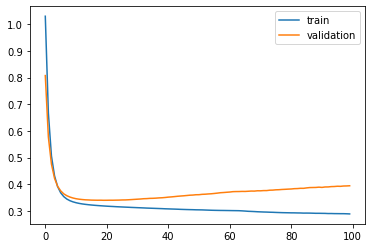

Time to train LSTM:  85.16732835769653
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 9s - loss: 1.1555 - acc: 0.6387 - val_loss: 0.9829 - val_acc: 0.7298

Epoch 00001: val_loss improved from inf to 0.98295, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.8771 - acc: 0.7707 - val_loss: 0.7850 - val_acc: 0.8048

Epoch 00002: val_loss improved from 0.98295 to 0.78501, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.7072 - acc: 0.8267 - val_loss: 0.6461 - val_acc: 0.8426

Epoch 00003: val_loss improved from 0.78501 to 0.64614, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5885 - acc: 0.8533 - val_loss: 0.5514 - val_acc: 0.8532

Epoch 00004: val_loss improved from 0.64614 to 0.55135, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5121 - acc: 0.8640 - val_loss: 0.4907 - val_acc: 0.8627

Epoch 00005: val_loss improved from 0.55135 to 0.49068, saving model to Post_val_weights1.hdf5
Epoch 6/100
 - 1

 - 1s - loss: 0.3040 - acc: 0.8829 - val_loss: 0.3446 - val_acc: 0.8675

Epoch 00051: val_loss did not improve from 0.33383
Epoch 52/100
 - 1s - loss: 0.3035 - acc: 0.8830 - val_loss: 0.3452 - val_acc: 0.8674

Epoch 00052: val_loss did not improve from 0.33383
Epoch 53/100
 - 1s - loss: 0.3031 - acc: 0.8831 - val_loss: 0.3457 - val_acc: 0.8677

Epoch 00053: val_loss did not improve from 0.33383
Epoch 54/100
 - 1s - loss: 0.3026 - acc: 0.8831 - val_loss: 0.3464 - val_acc: 0.8665

Epoch 00054: val_loss did not improve from 0.33383
Epoch 55/100
 - 1s - loss: 0.3023 - acc: 0.8833 - val_loss: 0.3467 - val_acc: 0.8670

Epoch 00055: val_loss did not improve from 0.33383
Epoch 56/100
 - 1s - loss: 0.3021 - acc: 0.8833 - val_loss: 0.3477 - val_acc: 0.8661

Epoch 00056: val_loss did not improve from 0.33383
Epoch 57/100
 - 1s - loss: 0.3016 - acc: 0.8834 - val_loss: 0.3480 - val_acc: 0.8668

Epoch 00057: val_loss did not improve from 0.33383
Epoch 58/100
 - 1s - loss: 0.3012 - acc: 0.8836 - val_

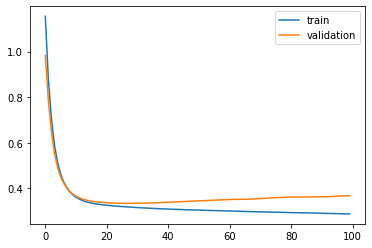

Time to train LSTM:  80.45899295806885
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 9s - loss: 1.1542 - acc: 0.6397 - val_loss: 0.9748 - val_acc: 0.7244

Epoch 00001: val_loss improved from inf to 0.97477, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.8753 - acc: 0.7726 - val_loss: 0.7744 - val_acc: 0.8060

Epoch 00002: val_loss improved from 0.97477 to 0.77443, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.7044 - acc: 0.8286 - val_loss: 0.6360 - val_acc: 0.8436

Epoch 00003: val_loss improved from 0.77443 to 0.63600, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5854 - acc: 0.8538 - val_loss: 0.5457 - val_acc: 0.8616

Epoch 00004: val_loss improved from 0.63600 to 0.54574, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5099 - acc: 0.8637 - val_loss: 0.4878 - val_acc: 0.8657

Epoch 00005: val_loss improved from 0.54574 to 0.48781, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 1


Epoch 00051: val_loss did not improve from 0.33405
Epoch 52/100
 - 1s - loss: 0.3020 - acc: 0.8830 - val_loss: 0.3503 - val_acc: 0.8671

Epoch 00052: val_loss did not improve from 0.33405
Epoch 53/100
 - 1s - loss: 0.3014 - acc: 0.8832 - val_loss: 0.3519 - val_acc: 0.8665

Epoch 00053: val_loss did not improve from 0.33405
Epoch 54/100
 - 1s - loss: 0.3010 - acc: 0.8832 - val_loss: 0.3520 - val_acc: 0.8664

Epoch 00054: val_loss did not improve from 0.33405
Epoch 55/100
 - 1s - loss: 0.3005 - acc: 0.8835 - val_loss: 0.3533 - val_acc: 0.8654

Epoch 00055: val_loss did not improve from 0.33405
Epoch 56/100
 - 1s - loss: 0.2999 - acc: 0.8838 - val_loss: 0.3542 - val_acc: 0.8655

Epoch 00056: val_loss did not improve from 0.33405
Epoch 57/100
 - 1s - loss: 0.2994 - acc: 0.8841 - val_loss: 0.3552 - val_acc: 0.8646

Epoch 00057: val_loss did not improve from 0.33405
Epoch 58/100
 - 1s - loss: 0.2990 - acc: 0.8844 - val_loss: 0.3567 - val_acc: 0.8637

Epoch 00058: val_loss did not improve fr

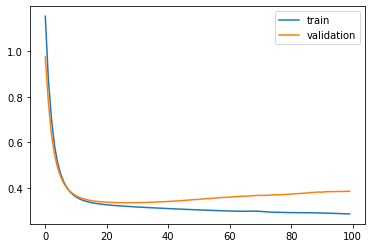

Time to train LSTM:  81.18636274337769
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 12s - loss: 1.1532 - acc: 0.6395 - val_loss: 0.9796 - val_acc: 0.7277

Epoch 00001: val_loss improved from inf to 0.97959, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.8747 - acc: 0.7725 - val_loss: 0.7836 - val_acc: 0.7989

Epoch 00002: val_loss improved from 0.97959 to 0.78365, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.7036 - acc: 0.8291 - val_loss: 0.6460 - val_acc: 0.8347

Epoch 00003: val_loss improved from 0.78365 to 0.64600, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5846 - acc: 0.8549 - val_loss: 0.5545 - val_acc: 0.8524

Epoch 00004: val_loss improved from 0.64600 to 0.55452, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5091 - acc: 0.8644 - val_loss: 0.4941 - val_acc: 0.8596

Epoch 00005: val_loss improved from 0.55452 to 0.49406, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 


Epoch 00051: val_loss did not improve from 0.34057
Epoch 52/100
 - 1s - loss: 0.3014 - acc: 0.8832 - val_loss: 0.3554 - val_acc: 0.8627

Epoch 00052: val_loss did not improve from 0.34057
Epoch 53/100
 - 1s - loss: 0.3009 - acc: 0.8834 - val_loss: 0.3562 - val_acc: 0.8616

Epoch 00053: val_loss did not improve from 0.34057
Epoch 54/100
 - 1s - loss: 0.3005 - acc: 0.8838 - val_loss: 0.3572 - val_acc: 0.8605

Epoch 00054: val_loss did not improve from 0.34057
Epoch 55/100
 - 1s - loss: 0.2999 - acc: 0.8840 - val_loss: 0.3576 - val_acc: 0.8611

Epoch 00055: val_loss did not improve from 0.34057
Epoch 56/100
 - 1s - loss: 0.2994 - acc: 0.8840 - val_loss: 0.3589 - val_acc: 0.8615

Epoch 00056: val_loss did not improve from 0.34057
Epoch 57/100
 - 1s - loss: 0.2988 - acc: 0.8843 - val_loss: 0.3592 - val_acc: 0.8618

Epoch 00057: val_loss did not improve from 0.34057
Epoch 58/100
 - 1s - loss: 0.2984 - acc: 0.8845 - val_loss: 0.3596 - val_acc: 0.8622

Epoch 00058: val_loss did not improve fr

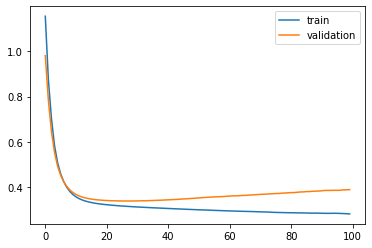

Time to train LSTM:  84.6982831954956
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 10s - loss: 1.1557 - acc: 0.6362 - val_loss: 0.9851 - val_acc: 0.7239

Epoch 00001: val_loss improved from inf to 0.98505, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.8766 - acc: 0.7706 - val_loss: 0.7839 - val_acc: 0.8006

Epoch 00002: val_loss improved from 0.98505 to 0.78389, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.7052 - acc: 0.8285 - val_loss: 0.6388 - val_acc: 0.8432

Epoch 00003: val_loss improved from 0.78389 to 0.63882, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5863 - acc: 0.8543 - val_loss: 0.5461 - val_acc: 0.8585

Epoch 00004: val_loss improved from 0.63882 to 0.54613, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5107 - acc: 0.8641 - val_loss: 0.4887 - val_acc: 0.8656

Epoch 00005: val_loss improved from 0.54613 to 0.48869, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 1


Epoch 00051: val_loss did not improve from 0.33456
Epoch 52/100
 - 1s - loss: 0.3025 - acc: 0.8830 - val_loss: 0.3475 - val_acc: 0.8682

Epoch 00052: val_loss did not improve from 0.33456
Epoch 53/100
 - 1s - loss: 0.3021 - acc: 0.8833 - val_loss: 0.3490 - val_acc: 0.8677

Epoch 00053: val_loss did not improve from 0.33456
Epoch 54/100
 - 1s - loss: 0.3017 - acc: 0.8834 - val_loss: 0.3491 - val_acc: 0.8677

Epoch 00054: val_loss did not improve from 0.33456
Epoch 55/100
 - 1s - loss: 0.3014 - acc: 0.8835 - val_loss: 0.3506 - val_acc: 0.8673

Epoch 00055: val_loss did not improve from 0.33456
Epoch 56/100
 - 1s - loss: 0.3011 - acc: 0.8834 - val_loss: 0.3514 - val_acc: 0.8661

Epoch 00056: val_loss did not improve from 0.33456
Epoch 57/100
 - 1s - loss: 0.3008 - acc: 0.8842 - val_loss: 0.3521 - val_acc: 0.8660

Epoch 00057: val_loss did not improve from 0.33456
Epoch 58/100
 - 1s - loss: 0.3003 - acc: 0.8841 - val_loss: 0.3524 - val_acc: 0.8669

Epoch 00058: val_loss did not improve fr

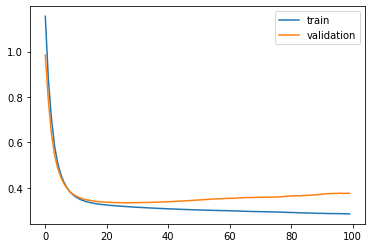

Time to train LSTM:  81.25735020637512
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 10s - loss: 1.1574 - acc: 0.6359 - val_loss: 0.9919 - val_acc: 0.7184

Epoch 00001: val_loss improved from inf to 0.99188, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.8775 - acc: 0.7710 - val_loss: 0.7910 - val_acc: 0.8007

Epoch 00002: val_loss improved from 0.99188 to 0.79098, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.7055 - acc: 0.8290 - val_loss: 0.6498 - val_acc: 0.8387

Epoch 00003: val_loss improved from 0.79098 to 0.64982, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5865 - acc: 0.8550 - val_loss: 0.5574 - val_acc: 0.8559

Epoch 00004: val_loss improved from 0.64982 to 0.55744, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5108 - acc: 0.8644 - val_loss: 0.4984 - val_acc: 0.8611

Epoch 00005: val_loss improved from 0.55744 to 0.49837, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 


Epoch 00051: val_loss did not improve from 0.34149
Epoch 52/100
 - 1s - loss: 0.3017 - acc: 0.8831 - val_loss: 0.3571 - val_acc: 0.8612

Epoch 00052: val_loss did not improve from 0.34149
Epoch 53/100
 - 1s - loss: 0.3011 - acc: 0.8832 - val_loss: 0.3583 - val_acc: 0.8607

Epoch 00053: val_loss did not improve from 0.34149
Epoch 54/100
 - 1s - loss: 0.3007 - acc: 0.8832 - val_loss: 0.3601 - val_acc: 0.8605

Epoch 00054: val_loss did not improve from 0.34149
Epoch 55/100
 - 1s - loss: 0.3003 - acc: 0.8835 - val_loss: 0.3613 - val_acc: 0.8606

Epoch 00055: val_loss did not improve from 0.34149
Epoch 56/100
 - 1s - loss: 0.2999 - acc: 0.8837 - val_loss: 0.3622 - val_acc: 0.8601

Epoch 00056: val_loss did not improve from 0.34149
Epoch 57/100
 - 1s - loss: 0.2995 - acc: 0.8839 - val_loss: 0.3635 - val_acc: 0.8598

Epoch 00057: val_loss did not improve from 0.34149
Epoch 58/100
 - 1s - loss: 0.2990 - acc: 0.8836 - val_loss: 0.3644 - val_acc: 0.8600

Epoch 00058: val_loss did not improve fr

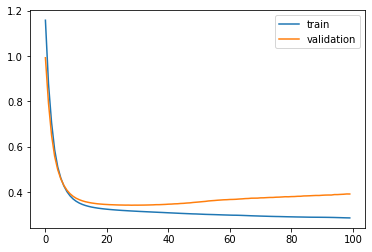

Time to train LSTM:  81.4754364490509


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f661d489710>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 11s - loss: 1.2493 - acc: 0.5888 - val_loss: 1.1192 - val_acc: 0.6570

Epoch 00001: val_loss improved from inf to 1.11919, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.0432 - acc: 0.6972 - val_loss: 0.9635 - val_acc: 0.7379

Epoch 00002: val_loss improved from 1.11919 to 0.96347, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.9074 - acc: 0.7589 - val_loss: 0.8494 - val_acc: 0.7794

Epoch 00003: val_loss improved from 0.96347 to 0.84940, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.8020 - acc: 0.7976 - val_loss: 0.7578 - val_acc: 0.8122

Epoch 00004: val_loss improved from 0.84940 to 0.75781, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.7144 - acc: 0.8253 - val_loss: 0.6802 - val_acc: 0.8337

Epoch 00005: val_loss improved from 0.75781 to 0.68018, saving model to Post_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.6410 - acc: 0.8437 - val_l

 - 1s - loss: 0.3158 - acc: 0.8783 - val_loss: 0.3384 - val_acc: 0.8681

Epoch 00046: val_loss improved from 0.33882 to 0.33845, saving model to Post_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3152 - acc: 0.8784 - val_loss: 0.3381 - val_acc: 0.8682

Epoch 00047: val_loss improved from 0.33845 to 0.33807, saving model to Post_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3145 - acc: 0.8784 - val_loss: 0.3378 - val_acc: 0.8681

Epoch 00048: val_loss improved from 0.33807 to 0.33776, saving model to Post_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3139 - acc: 0.8787 - val_loss: 0.3375 - val_acc: 0.8682

Epoch 00049: val_loss improved from 0.33776 to 0.33751, saving model to Post_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3131 - acc: 0.8790 - val_loss: 0.3375 - val_acc: 0.8678

Epoch 00050: val_loss improved from 0.33751 to 0.33746, saving model to Post_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3125 - acc: 0.8793 - val_loss: 0.3374 - val_acc: 0.8678

Epoch 00051: val_loss 

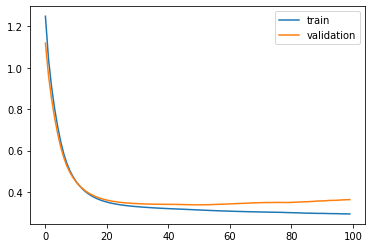

Time to train LSTM:  88.08752512931824
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 11s - loss: 1.2488 - acc: 0.5888 - val_loss: 1.1120 - val_acc: 0.6604

Epoch 00001: val_loss improved from inf to 1.11196, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.0425 - acc: 0.6980 - val_loss: 0.9562 - val_acc: 0.7337

Epoch 00002: val_loss improved from 1.11196 to 0.95620, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.9062 - acc: 0.7603 - val_loss: 0.8409 - val_acc: 0.7809

Epoch 00003: val_loss improved from 0.95620 to 0.84085, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.8002 - acc: 0.7993 - val_loss: 0.7474 - val_acc: 0.8135

Epoch 00004: val_loss improved from 0.84085 to 0.74744, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.7117 - acc: 0.8269 - val_loss: 0.6693 - val_acc: 0.8354

Epoch 00005: val_loss improved from 0.74744 to 0.66935, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 

 - 1s - loss: 0.3137 - acc: 0.8785 - val_loss: 0.3350 - val_acc: 0.8731

Epoch 00046: val_loss improved from 0.33500 to 0.33497, saving model to Post_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3130 - acc: 0.8788 - val_loss: 0.3350 - val_acc: 0.8731

Epoch 00047: val_loss improved from 0.33497 to 0.33496, saving model to Post_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3123 - acc: 0.8791 - val_loss: 0.3350 - val_acc: 0.8724

Epoch 00048: val_loss did not improve from 0.33496
Epoch 49/100
 - 1s - loss: 0.3117 - acc: 0.8793 - val_loss: 0.3351 - val_acc: 0.8722

Epoch 00049: val_loss did not improve from 0.33496
Epoch 50/100
 - 1s - loss: 0.3110 - acc: 0.8795 - val_loss: 0.3351 - val_acc: 0.8719

Epoch 00050: val_loss did not improve from 0.33496
Epoch 51/100
 - 1s - loss: 0.3103 - acc: 0.8799 - val_loss: 0.3352 - val_acc: 0.8718

Epoch 00051: val_loss did not improve from 0.33496
Epoch 52/100
 - 1s - loss: 0.3097 - acc: 0.8802 - val_loss: 0.3356 - val_acc: 0.8720

Epoch 00052: val_

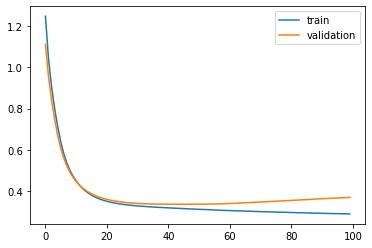

Time to train LSTM:  81.27614450454712
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 11s - loss: 1.2486 - acc: 0.5877 - val_loss: 1.1154 - val_acc: 0.6561

Epoch 00001: val_loss improved from inf to 1.11539, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.0423 - acc: 0.6978 - val_loss: 0.9616 - val_acc: 0.7360

Epoch 00002: val_loss improved from 1.11539 to 0.96156, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.9060 - acc: 0.7599 - val_loss: 0.8489 - val_acc: 0.7799

Epoch 00003: val_loss improved from 0.96156 to 0.84890, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.7999 - acc: 0.7990 - val_loss: 0.7572 - val_acc: 0.8049

Epoch 00004: val_loss improved from 0.84890 to 0.75723, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.7113 - acc: 0.8273 - val_loss: 0.6799 - val_acc: 0.8269

Epoch 00005: val_loss improved from 0.75723 to 0.67992, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 

 - 1s - loss: 0.3121 - acc: 0.8792 - val_loss: 0.3407 - val_acc: 0.8673

Epoch 00047: val_loss did not improve from 0.34003
Epoch 48/100
 - 1s - loss: 0.3115 - acc: 0.8797 - val_loss: 0.3409 - val_acc: 0.8675

Epoch 00048: val_loss did not improve from 0.34003
Epoch 49/100
 - 1s - loss: 0.3109 - acc: 0.8799 - val_loss: 0.3413 - val_acc: 0.8673

Epoch 00049: val_loss did not improve from 0.34003
Epoch 50/100
 - 1s - loss: 0.3103 - acc: 0.8801 - val_loss: 0.3416 - val_acc: 0.8660

Epoch 00050: val_loss did not improve from 0.34003
Epoch 51/100
 - 1s - loss: 0.3097 - acc: 0.8802 - val_loss: 0.3420 - val_acc: 0.8665

Epoch 00051: val_loss did not improve from 0.34003
Epoch 52/100
 - 1s - loss: 0.3090 - acc: 0.8805 - val_loss: 0.3422 - val_acc: 0.8657

Epoch 00052: val_loss did not improve from 0.34003
Epoch 53/100
 - 1s - loss: 0.3085 - acc: 0.8807 - val_loss: 0.3429 - val_acc: 0.8653

Epoch 00053: val_loss did not improve from 0.34003
Epoch 54/100
 - 1s - loss: 0.3079 - acc: 0.8808 - val_

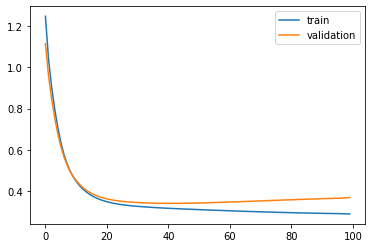

Time to train LSTM:  82.41073536872864
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 12s - loss: 1.2503 - acc: 0.5863 - val_loss: 1.1187 - val_acc: 0.6580

Epoch 00001: val_loss improved from inf to 1.11868, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.0435 - acc: 0.6961 - val_loss: 0.9659 - val_acc: 0.7315

Epoch 00002: val_loss improved from 1.11868 to 0.96588, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.9071 - acc: 0.7591 - val_loss: 0.8513 - val_acc: 0.7761

Epoch 00003: val_loss improved from 0.96588 to 0.85128, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.8012 - acc: 0.7990 - val_loss: 0.7554 - val_acc: 0.8108

Epoch 00004: val_loss improved from 0.85128 to 0.75540, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.7129 - acc: 0.8263 - val_loss: 0.6739 - val_acc: 0.8352

Epoch 00005: val_loss improved from 0.75540 to 0.67393, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 

 - 1s - loss: 0.3152 - acc: 0.8778 - val_loss: 0.3349 - val_acc: 0.8735

Epoch 00046: val_loss improved from 0.33490 to 0.33489, saving model to Post_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3145 - acc: 0.8781 - val_loss: 0.3350 - val_acc: 0.8735

Epoch 00047: val_loss did not improve from 0.33489
Epoch 48/100
 - 1s - loss: 0.3138 - acc: 0.8783 - val_loss: 0.3352 - val_acc: 0.8731

Epoch 00048: val_loss did not improve from 0.33489
Epoch 49/100
 - 1s - loss: 0.3131 - acc: 0.8785 - val_loss: 0.3353 - val_acc: 0.8730

Epoch 00049: val_loss did not improve from 0.33489
Epoch 50/100
 - 1s - loss: 0.3125 - acc: 0.8786 - val_loss: 0.3355 - val_acc: 0.8724

Epoch 00050: val_loss did not improve from 0.33489
Epoch 51/100
 - 1s - loss: 0.3119 - acc: 0.8789 - val_loss: 0.3357 - val_acc: 0.8723

Epoch 00051: val_loss did not improve from 0.33489
Epoch 52/100
 - 1s - loss: 0.3113 - acc: 0.8792 - val_loss: 0.3360 - val_acc: 0.8725

Epoch 00052: val_loss did not improve from 0.33489
Epoch 53/1

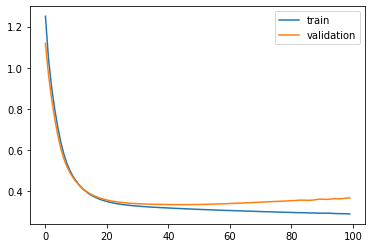

Time to train LSTM:  84.52903461456299
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 12s - loss: 1.2505 - acc: 0.5865 - val_loss: 1.1273 - val_acc: 0.6485

Epoch 00001: val_loss improved from inf to 1.12731, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.0439 - acc: 0.6960 - val_loss: 0.9716 - val_acc: 0.7280

Epoch 00002: val_loss improved from 1.12731 to 0.97158, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.9072 - acc: 0.7595 - val_loss: 0.8565 - val_acc: 0.7749

Epoch 00003: val_loss improved from 0.97158 to 0.85649, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.8009 - acc: 0.7991 - val_loss: 0.7621 - val_acc: 0.8088

Epoch 00004: val_loss improved from 0.85649 to 0.76208, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.7121 - acc: 0.8273 - val_loss: 0.6826 - val_acc: 0.8310

Epoch 00005: val_loss improved from 0.76208 to 0.68259, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 

 - 1s - loss: 0.3115 - acc: 0.8796 - val_loss: 0.3427 - val_acc: 0.8667

Epoch 00047: val_loss improved from 0.34285 to 0.34274, saving model to Post_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3108 - acc: 0.8799 - val_loss: 0.3427 - val_acc: 0.8671

Epoch 00048: val_loss improved from 0.34274 to 0.34268, saving model to Post_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3102 - acc: 0.8799 - val_loss: 0.3429 - val_acc: 0.8673

Epoch 00049: val_loss did not improve from 0.34268
Epoch 50/100
 - 1s - loss: 0.3096 - acc: 0.8801 - val_loss: 0.3433 - val_acc: 0.8663

Epoch 00050: val_loss did not improve from 0.34268
Epoch 51/100
 - 1s - loss: 0.3090 - acc: 0.8803 - val_loss: 0.3435 - val_acc: 0.8664

Epoch 00051: val_loss did not improve from 0.34268
Epoch 52/100
 - 1s - loss: 0.3084 - acc: 0.8805 - val_loss: 0.3439 - val_acc: 0.8665

Epoch 00052: val_loss did not improve from 0.34268
Epoch 53/100
 - 1s - loss: 0.3079 - acc: 0.8808 - val_loss: 0.3443 - val_acc: 0.8664

Epoch 00053: val_

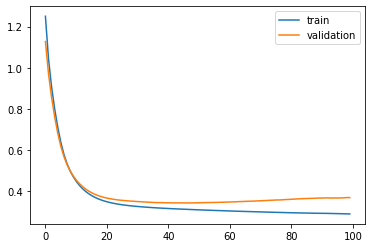

Time to train LSTM:  85.28174257278442
Entire process took:  4800.561390399933
Experiment record:
[[16, 512, 0, 0.33344130067797434], [16, 512, 1, 0.33365830542748437], [16, 512, 2, 0.3391906669892763], [16, 512, 3, 0.3334132865367577], [16, 512, 4, 0.3394083375122115], [16, 1024, 0, 0.3331538017172562], [16, 1024, 1, 0.33298310250566715], [16, 1024, 2, 0.3394669556757163], [16, 1024, 3, 0.33222298836847497], [16, 1024, 4, 0.33804537513102706], [16, 2048, 0, 0.32901830730382464], [16, 2048, 1, 0.3312898122915748], [16, 2048, 2, 0.3379315251565119], [16, 2048, 3, 0.3303973318749701], [16, 2048, 4, 0.33539121395663213], [16, 4096, 0, 0.32826085590479664], [16, 4096, 1, 0.3301164361538246], [16, 4096, 2, 0.3362120342394065], [16, 4096, 3, 0.32965048246913486], [16, 4096, 4, 0.3344200807844686], [16, 8192, 0, 0.3300208747317219], [16, 8192, 1, 0.330462209139651], [16, 8192, 2, 0.3360145849094056], [16, 8192, 3, 0.32807612699374816], [16, 8192, 4, 0.33612065163969296], [32, 512, 0, 0.335641

In [11]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [16,32] #[2,4,8,16,32]
batch_size_list = [512, 1024, 2048, 4096, 8192]# [256, 512, 1024, 2048, 4096]# 64,128,256, 512, 1024]#, 2048, 4096]#, 8192]

start_time = time.time()

exp_record = []

for units in units_list:
    for batch_s in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_lstm = np.append(train2_x, train1_x, axis=0) 
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_lstm = np.append(train2_y, train1_y, axis=0)
            ###############################
            seed(1)
            set_random_seed(1)
            ###############################
            start_time_inner = time.time()
            #config = tf.ConfigProto(log_device_placement = True)
            #config.gpu_options.visible_device_list='1'
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                model = Sequential()
                model.add(SimpleRNN(units, #CuDNNLSTM
                                    kernel_regularizer=regularizers.l2(0.01),
                                    #return_sequences=True, 
                                    input_shape=(8, 182))) #20 , 27
                #model.add(SimpleRNN(units, 
                #                    kernel_regularizer=regularizers.l2(0.01)))
                model.add(Dense(2, activation='softmax'))
                model.compile(loss='categorical_crossentropy', 
                              optimizer='adam', metrics=['accuracy'])
                val_weight = "Post_val_weights" + str(f+1) + ".hdf5"
                val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
                history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                    epochs=100, validation_split=0.1, 
                                    callbacks=[val_checkpointer], 
                                    verbose=2, 
                                    shuffle=False) 
                print("#################################")
                print("Number of units:", units)
                print("Batch size:", batch_s)
                print("Fold:", f)
                print("best val loss:", min(history.history['val_loss']))
                exp_record.append([units, batch_s, f, min(history.history['val_loss'])])
                print("#################################")
                if(f==4):
                    print(exp_record)
                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='validation')
                pyplot.legend()
                pyplot.show()
            end_time = time.time()
            print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [3]:
exp_record = [[1, 256, 0, 0.33373971937692654], [1, 256, 1, 0.33087750627980594], [1, 256, 2, 0.337586320394661], [1, 256, 3, 0.3321857688092349], [1, 256, 4, 0.33870807545226916], [1, 512, 0, 0.3310056498176173], [1, 512, 1, 0.3301281402334135], [1, 512, 2, 0.3366727458942703], [1, 512, 3, 0.3309771340074595], [1, 512, 4, 0.33624743742552415], [1, 1024, 0, 0.32872952579057707], [1, 1024, 1, 0.3285976597997877], [1, 1024, 2, 0.3362235160250413], [1, 1024, 3, 0.32911919812012835], [1, 1024, 4, 0.33549180959400376], [1, 2048, 0, 0.3289467690283792], [1, 2048, 1, 0.32835071831418755], [1, 2048, 2, 0.33851355123241045], [1, 2048, 3, 0.3303666505060698], [1, 2048, 4, 0.33569956366778814], [1, 4096, 0, 0.33192524474266677], [1, 4096, 1, 0.331446019111321], [1, 4096, 2, 0.33751572658444007], [1, 4096, 3, 0.33332109055323905], [1, 4096, 4, 0.33981251248839306], [2, 256, 0, 0.3263539231450934], [2, 256, 1, 0.32645767021597477], [2, 256, 2, 0.3291474593870821], [2, 256, 3, 0.32597644410635296], [2, 256, 4, 0.33174539766813577], [2, 512, 0, 0.32366034840979774], [2, 512, 1, 0.32601600946041576], [2, 512, 2, 0.3288598933345393], [2, 512, 3, 0.324121917123683], [2, 512, 4, 0.3296589992408864], [2, 1024, 0, 0.323465822077634], [2, 1024, 1, 0.32659017510581434], [2, 1024, 2, 0.3283320514779342], [2, 1024, 3, 0.3215137346446166], [2, 1024, 4, 0.32854372555749456], [2, 2048, 0, 0.32162549684619346], [2, 2048, 1, 0.3246906866804201], [2, 2048, 2, 0.32804700887691207], [2, 2048, 3, 0.32231379122761955], [2, 2048, 4, 0.33003979187959814], [2, 4096, 0, 0.32152968565622964], [2, 4096, 1, 0.3274307930887791], [2, 4096, 2, 0.3308543865583096], [2, 4096, 3, 0.3254021459573891], [2, 4096, 4, 0.33255067070325217], [4, 256, 0, 0.325794471523218], [4, 256, 1, 0.32559512870353563], [4, 256, 2, 0.33152923292235326], [4, 256, 3, 0.3275414863246226], [4, 256, 4, 0.33363133020568314], [4, 512, 0, 0.3258081548674065], [4, 512, 1, 0.3252046762154116], [4, 512, 2, 0.33122848609037564], [4, 512, 3, 0.3233371983912953], [4, 512, 4, 0.33186769327225046], [4, 1024, 0, 0.3235955278009002], [4, 1024, 1, 0.32753638616082265], [4, 1024, 2, 0.32990747700657763], [4, 1024, 3, 0.3234332045128471], [4, 1024, 4, 0.32849316480564095], [4, 2048, 0, 0.32275870544171475], [4, 2048, 1, 0.3245726459835008], [4, 2048, 2, 0.32840848748446905], [4, 2048, 3, 0.3224618855903023], [4, 2048, 4, 0.3315419124441537], [4, 4096, 0, 0.32238277055366693], [4, 4096, 1, 0.3294706178129765], [4, 4096, 2, 0.3291927848712743], [4, 4096, 3, 0.32517570245335675], [4, 4096, 4, 0.33069406777097465], [8, 256, 0, 0.33077406986415037], [8, 256, 1, 0.33092566218989633], [8, 256, 2, 0.333596356751626], [8, 256, 3, 0.3300971656166322], [8, 256, 4, 0.33745486787885254], [8, 512, 0, 0.3288329930472792], [8, 512, 1, 0.3300926153422796], [8, 512, 2, 0.33561725276255466], [8, 512, 3, 0.3287116362825472], [8, 512, 4, 0.3379042322802962], [8, 1024, 0, 0.3288948223186515], [8, 1024, 1, 0.3317811742163541], [8, 1024, 2, 0.3331390493445926], [8, 1024, 3, 0.3269019777872409], [8, 1024, 4, 0.3345437005109954], [8, 2048, 0, 0.32707936470271554], [8, 2048, 1, 0.32950529179377863], [8, 2048, 2, 0.3347000645336352], [8, 2048, 3, 0.3296172488851157], [8, 2048, 4, 0.333321427329939], [8, 4096, 0, 0.32702213060089025], [8, 4096, 1, 0.32769308581686857], [8, 4096, 2, 0.3334182149206686], [8, 4096, 3, 0.32857582691120124], [8, 4096, 4, 0.3337007244776564], [16, 256, 0, 0.3346934361694849], [16, 256, 1, 0.3332425984443977], [16, 256, 2, 0.33746642178610753], [16, 256, 3, 0.33143664015663993], [16, 256, 4, 0.3412931953605853], [16, 512, 0, 0.3301699568583951], [16, 512, 1, 0.3324853811277981], [16, 512, 2, 0.33617296469839], [16, 512, 3, 0.3345299708006675], [16, 512, 4, 0.3401655615212624], [16, 1024, 0, 0.3309552421765021], [16, 1024, 1, 0.3343099619979747], [16, 1024, 2, 0.33531423548508804], [16, 1024, 3, 0.3321164547978786], [16, 1024, 4, 0.3383660544986613], [16, 2048, 0, 0.32783758251290573], [16, 2048, 1, 0.3349672385753944], [16, 2048, 2, 0.33693749952734564], [16, 2048, 3, 0.33130132684930724], [16, 2048, 4, 0.3361893757602625], [16, 4096, 0, 0.32849209746422126], [16, 4096, 1, 0.3316592068212074], [16, 4096, 2, 0.33827894258917424], [16, 4096, 3, 0.3353203216421674], [16, 4096, 4, 0.33810724308616236]]

complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    #print("Val loss (mean):", np.mean(h_params[:, 3]))
    #print("Val loss (std):", np.std(h_params[:, 3]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 3]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 3]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 3]))
print(min(val_loss_list))

(125, 4)
###############################
Units: 1.0
Batch size: 256.0
Val loss (mean): 0.33462
Val loss (std): 0.00304
###############################
###############################
Units: 1.0
Batch size: 512.0
Val loss (mean): 0.33301
Val loss (std): 0.00284
###############################
###############################
Units: 1.0
Batch size: 1024.0
Val loss (mean): 0.33163
Val loss (std): 0.00346
###############################
###############################
Units: 1.0
Batch size: 2048.0
Val loss (mean): 0.33238
Val loss (std): 0.00402
###############################
###############################
Units: 1.0
Batch size: 4096.0
Val loss (mean): 0.3348
Val loss (std): 0.00329
###############################
###############################
Units: 2.0
Batch size: 256.0
Val loss (mean): 0.32794
Val loss (std): 0.00221
###############################
###############################
Units: 2.0
Batch size: 512.0
Val loss (mean): 0.32646
Val loss (std): 0.00243
###########################

In [14]:
units = 1
model = Sequential()
model.add(CuDNNLSTM(units, 
                    kernel_regularizer=regularizers.l2(0.01),
                    #return_sequences=True, 
                    input_shape=(4, 182))) #20 , 27
#model.add(CuDNNLSTM(units, 
#                    kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_126 (CuDNNLSTM)   (None, 1)                 740       
_________________________________________________________________
dense_127 (Dense)            (None, 2)                 4         
Total params: 744
Trainable params: 744
Non-trainable params: 0
_________________________________________________________________


In [10]:
###########################
# generate random numbers
# for layer 1 and 2 
# L2 search
###########################
from numpy.random import seed
seed(29) # seed 13 for LSTM seed 16 for SimpleRNN (16 to 4)
         # seed 18 for LSTM seed for 19 SimpleRNN (4 to 4)
         # seed 4 for LSTM  7 for SimpleRNN (16 to 4) 1 layer
         # seed 8 for LSTM  9 for SimpleRNN  (4 to 4) 1 layer
         # seed 22 for LSTM  23 for SimpleRNN (12 to 4) 1layer   
         # seed 28 for LSTM 29 for SimpleRNN (8 to 4) 1layer
# L2 for layer 1 between 0.005 and 0.015
L2_1_list = []
for i in range(25):
    L2_1_list.append(np.random.uniform(0.005, 0.015))
# L2 for layer 2 between 1e-4 and 1e-8
L2_2_list = []
for i in range(25):
    r = -4*np.random.rand()
    s = 0.0001*(10**r)
    L2_2_list.append(s)
print("Min L2 layer 1:\t", min(L2_1_list))
print("Max L2 layer 1:\t", max(L2_1_list))
print("Min L2 layer 2:\t", min(L2_2_list))
print("Max L2 layer 2:\t", max(L2_2_list))
print("Layer 1 L2:\t", L2_1_list)
print("Layer 2 L2:\t", L2_2_list)

Min L2 layer 1:	 0.00500063495754628
Max L2 layer 1:	 0.01456012400954233
Min L2 layer 2:	 1.1490073473552646e-08
Max L2 layer 2:	 4.6407510846938845e-05
Layer 1 L2:	 [0.013637599855700826, 0.007849059652276268, 0.00573256388083736, 0.012632372043302849, 0.009527190575994113, 0.010422968740087744, 0.012266357828275072, 0.013489051076148218, 0.012681999778089821, 0.012331437233200173, 0.007419864247038851, 0.012203086925547387, 0.005583773058117212, 0.009096689261577843, 0.0111067227385766, 0.0075591487456188825, 0.007856719275463319, 0.011844637468101177, 0.013409197353885589, 0.013091534201008212, 0.00500063495754628, 0.014236100947219523, 0.01306965163145652, 0.01456012400954233, 0.009847289899093989]
Layer 2 L2:	 [2.2371957504223983e-07, 1.1608426866140592e-07, 1.366317063276529e-06, 6.000773098573809e-08, 1.770312290714157e-06, 3.0467787559539307e-05, 2.7002110552468955e-07, 1.2173772675801509e-06, 2.3308638794421389e-07, 4.6407510846938845e-05, 2.2136423090180878e-07, 1.0870253187

In [14]:
### from numpy.random import seed
seed(5) # seed 13 for LSTM seed 16 for SimpleRNN (16 to 4)
         # seed 18 for LSTM seed for 19 SimpleRNN (4 to 4)
         # seed 1 for SimpleRNN extend 1 layer
         # seed 5 for LSTM extend 1 layer
# L2 for layer 1 between 0.005 and 0.015
L2_1_list = []
for i in range(5):
    L2_1_list.append(np.random.uniform(0.003, 0.005))
# L2 for layer 2 between 1e-4 and 1e-8
L2_2_list = []
for i in range(5):
    r = -2*np.random.rand()
    s = 0.000001*(10**r)
    L2_2_list.append(s)
print("Min L2 layer 1:\t", min(L2_1_list))
print("Max L2 layer 1:\t", max(L2_1_list))
print("Min L2 layer 2:\t", min(L2_2_list))
print("Max L2 layer 2:\t", max(L2_2_list))
print("Layer 1 L2:\t", L2_1_list)
print("Layer 2 L2:\t", L2_2_list)


Min L2 layer 1:	 0.003413438310678853
Max L2 layer 1:	 0.0048372218158758435
Min L2 layer 2:	 2.9388964687128024e-08
Max L2 layer 2:	 4.2126709964605095e-07
Layer 1 L2:	 [0.003443986342179479, 0.004741464612354753, 0.003413438310678853, 0.0048372218158758435, 0.003976822377589659]
Layer 2 L2:	 [5.977399380019084e-08, 2.9388964687128024e-08, 9.186794976618292e-08, 2.5491711623149535e-07, 4.2126709964605095e-07]


8550
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.8579 - acc: 0.5717 - val_loss: 0.7797 - val_acc: 0.6313

Epoch 00001: val_loss improved from inf to 0.77970, saving model to Post_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7259 - acc: 0.6715 - val_loss: 0.6729 - val_acc: 0.7130

Epoch 00002: val_loss improved from 0.77970 to 0.67291, saving model to Post_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6285 - acc: 0.7434 - val_loss: 0.5884 - val_acc: 0.7696

Epoch 00003: val_loss improved from 0.67291 to 0.58843, saving model to Post_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5478 - acc: 0.7916 - val_loss: 0.5167 - val_acc: 0.8051

Epoch 00004: val_loss improved from 0.58843 to 0.51675, saving model to Post_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.4805 - acc: 0.8247 - val_loss: 0.4596 - val_acc: 0.8347

Epoch 00005: val_loss imp

 - 1s - loss: 0.3181 - acc: 0.8744 - val_loss: 0.3256 - val_acc: 0.8729

Epoch 00043: val_loss improved from 0.32569 to 0.32558, saving model to Post_val_weights1.hdf5
Epoch 44/100
 - 1s - loss: 0.3179 - acc: 0.8746 - val_loss: 0.3255 - val_acc: 0.8731

Epoch 00044: val_loss improved from 0.32558 to 0.32546, saving model to Post_val_weights1.hdf5
Epoch 45/100
 - 1s - loss: 0.3178 - acc: 0.8745 - val_loss: 0.3254 - val_acc: 0.8731

Epoch 00045: val_loss improved from 0.32546 to 0.32536, saving model to Post_val_weights1.hdf5
Epoch 46/100
 - 1s - loss: 0.3176 - acc: 0.8747 - val_loss: 0.3253 - val_acc: 0.8732

Epoch 00046: val_loss improved from 0.32536 to 0.32526, saving model to Post_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3175 - acc: 0.8746 - val_loss: 0.3252 - val_acc: 0.8731

Epoch 00047: val_loss improved from 0.32526 to 0.32517, saving model to Post_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3174 - acc: 0.8746 - val_loss: 0.3252 - val_acc: 0.8730

Epoch 00048: val_loss 

 - 1s - loss: 0.3141 - acc: 0.8754 - val_loss: 0.3233 - val_acc: 0.8718

Epoch 00091: val_loss improved from 0.32333 to 0.32331, saving model to Post_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3141 - acc: 0.8755 - val_loss: 0.3232 - val_acc: 0.8718

Epoch 00092: val_loss improved from 0.32331 to 0.32324, saving model to Post_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3140 - acc: 0.8756 - val_loss: 0.3233 - val_acc: 0.8717

Epoch 00093: val_loss did not improve from 0.32324
Epoch 94/100
 - 1s - loss: 0.3140 - acc: 0.8756 - val_loss: 0.3232 - val_acc: 0.8716

Epoch 00094: val_loss improved from 0.32324 to 0.32320, saving model to Post_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3139 - acc: 0.8756 - val_loss: 0.3232 - val_acc: 0.8716

Epoch 00095: val_loss did not improve from 0.32320
Epoch 96/100
 - 1s - loss: 0.3139 - acc: 0.8757 - val_loss: 0.3232 - val_acc: 0.8715

Epoch 00096: val_loss improved from 0.32320 to 0.32316, saving model to Post_val_weights1.hdf5
Epoch 97/100
 -

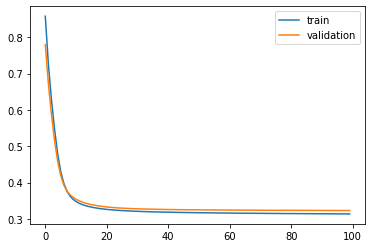

Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 1s - loss: 0.8575 - acc: 0.5723 - val_loss: 0.7807 - val_acc: 0.6291

Epoch 00001: val_loss improved from inf to 0.78071, saving model to Post_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7257 - acc: 0.6708 - val_loss: 0.6712 - val_acc: 0.7097

Epoch 00002: val_loss improved from 0.78071 to 0.67116, saving model to Post_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6283 - acc: 0.7434 - val_loss: 0.5853 - val_acc: 0.7683

Epoch 00003: val_loss improved from 0.67116 to 0.58526, saving model to Post_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5478 - acc: 0.7916 - val_loss: 0.5106 - val_acc: 0.8104

Epoch 00004: val_loss improved from 0.58526 to 0.51062, saving model to Post_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.4809 - acc: 0.8245 - val_loss: 0.4531 - val_acc: 0.8381

Epoch 00005: val_loss improved from 0.51062 to 0.45313, saving model to Post_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4313 - acc: 0.8452 - val_lo

 - 1s - loss: 0.3171 - acc: 0.8746 - val_loss: 0.3279 - val_acc: 0.8730

Epoch 00047: val_loss improved from 0.32798 to 0.32792, saving model to Post_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3170 - acc: 0.8748 - val_loss: 0.3279 - val_acc: 0.8726

Epoch 00048: val_loss improved from 0.32792 to 0.32790, saving model to Post_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3169 - acc: 0.8749 - val_loss: 0.3277 - val_acc: 0.8729

Epoch 00049: val_loss improved from 0.32790 to 0.32774, saving model to Post_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3167 - acc: 0.8751 - val_loss: 0.3276 - val_acc: 0.8725

Epoch 00050: val_loss improved from 0.32774 to 0.32763, saving model to Post_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3166 - acc: 0.8751 - val_loss: 0.3280 - val_acc: 0.8719

Epoch 00051: val_loss did not improve from 0.32763
Epoch 52/100
 - 1s - loss: 0.3165 - acc: 0.8751 - val_loss: 0.3279 - val_acc: 0.8720

Epoch 00052: val_loss did not improve from 0.32763
Epoch 53/100
 -

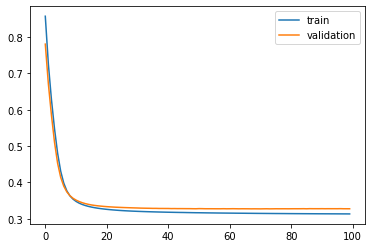

Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 1s - loss: 0.8568 - acc: 0.5725 - val_loss: 0.7859 - val_acc: 0.6232

Epoch 00001: val_loss improved from inf to 0.78595, saving model to Post_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7256 - acc: 0.6704 - val_loss: 0.6762 - val_acc: 0.7132

Epoch 00002: val_loss improved from 0.78595 to 0.67624, saving model to Post_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6287 - acc: 0.7430 - val_loss: 0.5905 - val_acc: 0.7667

Epoch 00003: val_loss improved from 0.67624 to 0.59054, saving model to Post_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5482 - acc: 0.7915 - val_loss: 0.5194 - val_acc: 0.8037

Epoch 00004: val_loss improved from 0.59054 to 0.51936, saving model to Post_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4808 - acc: 0.8246 - val_loss: 0.4629 - val_acc: 0.8297

Epoch 00005: val_loss improved from 0.51936 to 0.46295, saving model to Post_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4308 - acc: 0.8458 - val_lo

 - 1s - loss: 0.3166 - acc: 0.8752 - val_loss: 0.3325 - val_acc: 0.8656

Epoch 00046: val_loss improved from 0.33249 to 0.33248, saving model to Post_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3165 - acc: 0.8753 - val_loss: 0.3324 - val_acc: 0.8658

Epoch 00047: val_loss improved from 0.33248 to 0.33235, saving model to Post_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3163 - acc: 0.8754 - val_loss: 0.3323 - val_acc: 0.8662

Epoch 00048: val_loss improved from 0.33235 to 0.33233, saving model to Post_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3162 - acc: 0.8753 - val_loss: 0.3322 - val_acc: 0.8665

Epoch 00049: val_loss improved from 0.33233 to 0.33223, saving model to Post_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3161 - acc: 0.8753 - val_loss: 0.3322 - val_acc: 0.8667

Epoch 00050: val_loss did not improve from 0.33223
Epoch 51/100
 - 1s - loss: 0.3159 - acc: 0.8753 - val_loss: 0.3321 - val_acc: 0.8665

Epoch 00051: val_loss improved from 0.33223 to 0.33210, saving mod

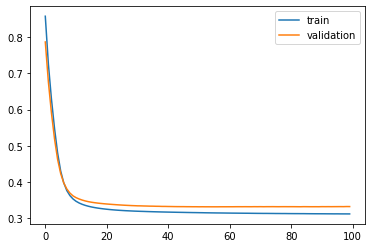

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe230475a90>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 1s - loss: 0.8570 - acc: 0.5729 - val_loss: 0.7872 - val_acc: 0.6242

Epoch 00001: val_loss improved from inf to 0.78723, saving model to Post_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7252 - acc: 0.6714 - val_loss: 0.6802 - val_acc: 0.7077

Epoch 00002: val_loss improved from 0.78723 to 0.68016, saving model to Post_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6279 - acc: 0.7441 - val_loss: 0.5948 - val_acc: 0.7616

Epoch 00003: val_loss improved from 0.68016 to 0.59483, saving model to Post_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5476 - acc: 0.7917 - val_loss: 0.5197 - val_acc: 0.8067

Epoch 00004: val_loss improved from 0.59483 to 0.51972, saving model to Post_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.4807 - acc: 0.8243 - val_loss: 0.4599 - val_acc: 0.8345

Epoch 00005: val_loss improved from 0.51972 to 0.45985, saving model to Post_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4310 - acc: 0.8459 - val_lo

 - 1s - loss: 0.3174 - acc: 0.8750 - val_loss: 0.3265 - val_acc: 0.8736

Epoch 00046: val_loss improved from 0.32661 to 0.32653, saving model to Post_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3173 - acc: 0.8749 - val_loss: 0.3264 - val_acc: 0.8736

Epoch 00047: val_loss improved from 0.32653 to 0.32639, saving model to Post_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3172 - acc: 0.8748 - val_loss: 0.3263 - val_acc: 0.8738

Epoch 00048: val_loss improved from 0.32639 to 0.32631, saving model to Post_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3170 - acc: 0.8748 - val_loss: 0.3262 - val_acc: 0.8737

Epoch 00049: val_loss improved from 0.32631 to 0.32622, saving model to Post_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3169 - acc: 0.8748 - val_loss: 0.3261 - val_acc: 0.8738

Epoch 00050: val_loss improved from 0.32622 to 0.32612, saving model to Post_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3168 - acc: 0.8749 - val_loss: 0.3260 - val_acc: 0.8736

Epoch 00051: val_loss 


Epoch 00096: val_loss did not improve from 0.32456
Epoch 97/100
 - 1s - loss: 0.3131 - acc: 0.8753 - val_loss: 0.3255 - val_acc: 0.8731

Epoch 00097: val_loss did not improve from 0.32456
Epoch 98/100
 - 1s - loss: 0.3130 - acc: 0.8752 - val_loss: 0.3256 - val_acc: 0.8733

Epoch 00098: val_loss did not improve from 0.32456
Epoch 99/100
 - 1s - loss: 0.3130 - acc: 0.8752 - val_loss: 0.3257 - val_acc: 0.8732

Epoch 00099: val_loss did not improve from 0.32456
Epoch 100/100
 - 1s - loss: 0.3129 - acc: 0.8752 - val_loss: 0.3257 - val_acc: 0.8731

Epoch 00100: val_loss did not improve from 0.32456
#################################
Number of units: 8
Batch size: 4096
Fold: 3
L2_1: 0.009847289899093989
best val loss: 0.324557525198362
#################################


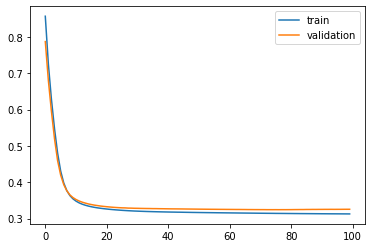

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe2143bc2e8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 76950 samples, validate on 8550 samples
Epoch 1/100
 - 2s - loss: 0.8588 - acc: 0.5722 - val_loss: 0.7800 - val_acc: 0.6242

Epoch 00001: val_loss improved from inf to 0.77999, saving model to Post_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7273 - acc: 0.6704 - val_loss: 0.6723 - val_acc: 0.7118

Epoch 00002: val_loss improved from 0.77999 to 0.67233, saving model to Post_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6300 - acc: 0.7432 - val_loss: 0.5876 - val_acc: 0.7665

Epoch 00003: val_loss improved from 0.67233 to 0.58765, saving model to Post_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5491 - acc: 0.7912 - val_loss: 0.5151 - val_acc: 0.8047

Epoch 00004: val_loss improved from 0.58765 to 0.51511, saving model to Post_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.4814 - acc: 0.8247 - val_loss: 0.4589 - val_acc: 0.8329

Epoch 00005: val_loss improved from 0.51511 to 0.45892, saving model to Post_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4314 - acc: 0.8451 - val_lo


Epoch 00046: val_loss improved from 0.33260 to 0.33250, saving model to Post_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3167 - acc: 0.8753 - val_loss: 0.3324 - val_acc: 0.8663

Epoch 00047: val_loss improved from 0.33250 to 0.33243, saving model to Post_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3166 - acc: 0.8753 - val_loss: 0.3323 - val_acc: 0.8662

Epoch 00048: val_loss improved from 0.33243 to 0.33232, saving model to Post_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3164 - acc: 0.8753 - val_loss: 0.3322 - val_acc: 0.8662

Epoch 00049: val_loss improved from 0.33232 to 0.33223, saving model to Post_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3163 - acc: 0.8753 - val_loss: 0.3322 - val_acc: 0.8662

Epoch 00050: val_loss improved from 0.33223 to 0.33217, saving model to Post_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3162 - acc: 0.8755 - val_loss: 0.3321 - val_acc: 0.8663

Epoch 00051: val_loss improved from 0.33217 to 0.33206, saving model to Post_val_weights5.hdf5

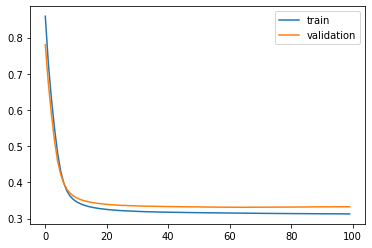

Time to train LSTM:  66.28643369674683
Entire process took:  325.6279122829437
Experiment record:
[[8, 4096, 0.009847289899093989, 0, 0.3230706051497432], [8, 4096, 0.009847289899093989, 1, 0.3273032117587084], [8, 4096, 0.009847289899093989, 2, 0.33204920897009776], [8, 4096, 0.009847289899093989, 3, 0.324557525198362], [8, 4096, 0.009847289899093989, 4, 0.3311056639088525]]


In [11]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units = 8
batch_s = 4096

L2_1_list = [0.009847289899093989]
#L2_1_list = [0.005061408663460982, 0.012720438714445361, 0.01457832168093275, 0.012019378840943111, 0.007975782668650504, 0.012679927419555908, 0.011882183248926141, 0.008871834803810222, 0.01115205825093056, 0.009275552398443406]
start_time = time.time()

exp_record = []

for i in range(len(L2_1_list)):
    L2_1 = L2_1_list[i]
    #L2_2 = L2_2_list[i]
    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_lstm = np.append(train2_x, train1_x, axis=0) 
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_lstm = np.append(train2_y, train1_y, axis=0)
        #######################
        seed(1)
        set_random_seed(1)
        #######################
        start_time_inner = time.time()
        #config = tf.ConfigProto(log_device_placement = True)
        #config.gpu_options.visible_device_list='1'
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = Sequential()
            model.add(SimpleRNN(units, #CuDNNLSTM
                                kernel_regularizer=regularizers.l2(L2_1),
                                #return_sequences=True, 
                                input_shape=(8, 182))) 
            #model.add(CuDNNLSTM(units, 
            #                    kernel_regularizer=regularizers.l2(L2_2)))
            model.add(Dense(2, activation='softmax'))
            #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
            #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7) 
            model.compile(loss='categorical_crossentropy', 
                          optimizer='adam', metrics=['accuracy'])
            val_weight = "Post_val_weights" + str(f+1) + ".hdf5"
            val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                               monitor='val_loss', verbose=1,
                                               save_best_only=True)
            history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                epochs=100, validation_split=0.1, 
                                callbacks=[val_checkpointer], 
                                verbose=2, 
                                shuffle=False) 
            print("#################################")
            print("Number of units:", units)
            print("Batch size:", batch_s)
            print("Fold:", f)
            print("L2_1:", L2_1)
            #print("L2_2:", L2_2)
            print("best val loss:", min(history.history['val_loss']))
            exp_record.append([units, batch_s, L2_1, f, min(history.history['val_loss'])])
            #exp_record.append([units, batch_s, L2_1, L2_2, f, min(history.history['val_loss'])])
            print("#################################")
            if(f==4):
                print(exp_record)
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='validation')
            pyplot.legend()
            pyplot.show()
    end_time = time.time()
    print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [12]:
exp_record = [[8, 4096, 0.013637599855700826, 0, 0.32415541849638285], [8, 4096, 0.013637599855700826, 1, 0.328797492841531], [8, 4096, 0.013637599855700826, 2, 0.3336404241595352], [8, 4096, 0.013637599855700826, 3, 0.3260851768443459], [8, 4096, 0.013637599855700826, 4, 0.3330834898753473], [8, 4096, 0.007849059652276268, 0, 0.3234921474833237], [8, 4096, 0.007849059652276268, 1, 0.3271810264824427], [8, 4096, 0.007849059652276268, 2, 0.3322985153100644], [8, 4096, 0.007849059652276268, 3, 0.32392454699466106], [8, 4096, 0.007849059652276268, 4, 0.33133533448503727], [8, 4096, 0.00573256388083736, 0, 0.32430463897554496], [8, 4096, 0.00573256388083736, 1, 0.32689393519658094], [8, 4096, 0.00573256388083736, 2, 0.3324947276519753], [8, 4096, 0.00573256388083736, 3, 0.3253669369708725], [8, 4096, 0.00573256388083736, 4, 0.3325899460580614], [8, 4096, 0.012632372043302849, 0, 0.3235187980236366], [8, 4096, 0.012632372043302849, 1, 0.3284282022400906], [8, 4096, 0.012632372043302849, 2, 0.33292572780659324], [8, 4096, 0.012632372043302849, 3, 0.3248028986844403], [8, 4096, 0.012632372043302849, 4, 0.3328416218952826], [8, 4096, 0.009527190575994113, 0, 0.32314381766040423], [8, 4096, 0.009527190575994113, 1, 0.327473776005862], [8, 4096, 0.009527190575994113, 2, 0.3319953565430223], [8, 4096, 0.009527190575994113, 3, 0.32406300855658904], [8, 4096, 0.009527190575994113, 4, 0.33105038348694293], [8, 4096, 0.010422968740087744, 0, 0.323199686697352], [8, 4096, 0.010422968740087744, 1, 0.3274111739236709], [8, 4096, 0.010422968740087744, 2, 0.33219186232103937], [8, 4096, 0.010422968740087744, 3, 0.3254736132231372], [8, 4096, 0.010422968740087744, 4, 0.33166261516119305], [8, 4096, 0.012266357828275072, 0, 0.3234781904318179], [8, 4096, 0.012266357828275072, 1, 0.3282874966852846], [8, 4096, 0.012266357828275072, 2, 0.33251611344298426], [8, 4096, 0.012266357828275072, 3, 0.3248279383447435], [8, 4096, 0.012266357828275072, 4, 0.3328117259831456], [8, 4096, 0.013489051076148218, 0, 0.32349211268257677], [8, 4096, 0.013489051076148218, 1, 0.32887475906059754], [8, 4096, 0.013489051076148218, 2, 0.33334807790510834], [8, 4096, 0.013489051076148218, 3, 0.3258923501577991], [8, 4096, 0.013489051076148218, 4, 0.33304327064090306], [8, 4096, 0.012681999778089821, 0, 0.32375161075452613], [8, 4096, 0.012681999778089821, 1, 0.32847715918083636], [8, 4096, 0.012681999778089821, 2, 0.3328903889656067], [8, 4096, 0.012681999778089821, 3, 0.32485783544200203], [8, 4096, 0.012681999778089821, 4, 0.3328080089050427], [8, 4096, 0.012331437233200173, 0, 0.32333060463966684], [8, 4096, 0.012331437233200173, 1, 0.32828347930434154], [8, 4096, 0.012331437233200173, 2, 0.33255407479074267], [8, 4096, 0.012331437233200173, 3, 0.32488117417396856], [8, 4096, 0.012331437233200173, 4, 0.3326774081291511], [8, 4096, 0.007419864247038851, 0, 0.3233692505624559], [8, 4096, 0.007419864247038851, 1, 0.32721156606200147], [8, 4096, 0.007419864247038851, 2, 0.33271728849550436], [8, 4096, 0.007419864247038851, 3, 0.32417496813668145], [8, 4096, 0.007419864247038851, 4, 0.3314633682178475], [8, 4096, 0.012203086925547387, 0, 0.3238162960992222], [8, 4096, 0.012203086925547387, 1, 0.32825103121194227], [8, 4096, 0.012203086925547387, 2, 0.33239174885359424], [8, 4096, 0.012203086925547387, 3, 0.3249226434746681], [8, 4096, 0.012203086925547387, 4, 0.3328105481047379], [8, 4096, 0.005583773058117212, 0, 0.3244263251343666], [8, 4096, 0.005583773058117212, 1, 0.32679621785704854], [8, 4096, 0.005583773058117212, 2, 0.33247265136729903], [8, 4096, 0.005583773058117212, 3, 0.325100645698302], [8, 4096, 0.005583773058117212, 4, 0.33253972699070533], [8, 4096, 0.009096689261577843, 0, 0.32292151197355395], [8, 4096, 0.009096689261577843, 1, 0.3274908230179235], [8, 4096, 0.009096689261577843, 2, 0.3320276365642659], [8, 4096, 0.009096689261577843, 3, 0.32399680794331065], [8, 4096, 0.009096689261577843, 4, 0.33119615646133643], [8, 4096, 0.0111067227385766, 0, 0.32343410181720356], [8, 4096, 0.0111067227385766, 1, 0.3275030647871787], [8, 4096, 0.0111067227385766, 2, 0.3323815730092121], [8, 4096, 0.0111067227385766, 3, 0.3249447660975986], [8, 4096, 0.0111067227385766, 4, 0.3323992367655213], [8, 4096, 0.0075591487456188825, 0, 0.3233579979305379], [8, 4096, 0.0075591487456188825, 1, 0.32733345440256667], [8, 4096, 0.0075591487456188825, 2, 0.3326135721123009], [8, 4096, 0.0075591487456188825, 3, 0.32431020930496574], [8, 4096, 0.0075591487456188825, 4, 0.3313925801034559], [8, 4096, 0.007856719275463319, 0, 0.32344832708961085], [8, 4096, 0.007856719275463319, 1, 0.3271349229240975], [8, 4096, 0.007856719275463319, 2, 0.3322886445578079], [8, 4096, 0.007856719275463319, 3, 0.3238835867036853], [8, 4096, 0.007856719275463319, 4, 0.33132802236847014], [8, 4096, 0.011844637468101177, 0, 0.3235182853609498], [8, 4096, 0.011844637468101177, 1, 0.3282395578755273], [8, 4096, 0.011844637468101177, 2, 0.3320332533504531], [8, 4096, 0.011844637468101177, 3, 0.3248659537967883], [8, 4096, 0.011844637468101177, 4, 0.3328129621834783], [8, 4096, 0.013409197353885589, 0, 0.323772089739292], [8, 4096, 0.013409197353885589, 1, 0.32879548136253806], [8, 4096, 0.013409197353885589, 2, 0.3332476043840598], [8, 4096, 0.013409197353885589, 3, 0.3257705068169979], [8, 4096, 0.013409197353885589, 4, 0.3330293974193216], [8, 4096, 0.013091534201008212, 0, 0.32379583906709103], [8, 4096, 0.013091534201008212, 1, 0.3286413802180374], [8, 4096, 0.013091534201008212, 2, 0.33308866548956484], [8, 4096, 0.013091534201008212, 3, 0.3250617655397159], [8, 4096, 0.013091534201008212, 4, 0.3327826297980303], [8, 4096, 0.00500063495754628, 0, 0.32385322317045334], [8, 4096, 0.00500063495754628, 1, 0.3267437319030539], [8, 4096, 0.00500063495754628, 2, 0.3321993997292212], [8, 4096, 0.00500063495754628, 3, 0.3247981286118602], [8, 4096, 0.00500063495754628, 4, 0.33245356048059743], [8, 4096, 0.014236100947219523, 0, 0.3263320689382609], [8, 4096, 0.014236100947219523, 1, 0.3287192872881192], [8, 4096, 0.014236100947219523, 2, 0.33326341408038], [8, 4096, 0.014236100947219523, 3, 0.3265016420124567], [8, 4096, 0.014236100947219523, 4, 0.33318215060652345], [8, 4096, 0.01306965163145652, 0, 0.32376977259652656], [8, 4096, 0.01306965163145652, 1, 0.3287034447011892], [8, 4096, 0.01306965163145652, 2, 0.33308406772669297], [8, 4096, 0.01306965163145652, 3, 0.32494522384035657], [8, 4096, 0.01306965163145652, 4, 0.33291676927728264], [8, 4096, 0.01456012400954233, 0, 0.32597265449183727], [8, 4096, 0.01456012400954233, 1, 0.3290702944192273], [8, 4096, 0.01456012400954233, 2, 0.33344563040816994], [8, 4096, 0.01456012400954233, 3, 0.3265323549962183], [8, 4096, 0.01456012400954233, 4, 0.33338806383093894], [8, 4096, 0.009847289899093989, 0, 0.3230706051497432], [8, 4096, 0.009847289899093989, 1, 0.3273032117587084], [8, 4096, 0.009847289899093989, 2, 0.33204920897009776], [8, 4096, 0.009847289899093989, 3, 0.324557525198362], [8, 4096, 0.009847289899093989, 4, 0.3311056639088525]]


complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    print("L2 1:", h_params[0, 2])
    #print("h2 2:", h_params[0, 3])
    #print("Val loss (mean):", np.mean(h_params[:, 5]))
    #print("Val loss (std):", np.std(h_params[:, 5]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 4]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 4]), decimals=5))
    print("###############################")
    
    val_loss_list.append(np.mean(h_params[:, 4]))
print("Min Val loss:", min(val_loss_list))
print("Min L2 1:", min(complete_v[:, 2]))
#print("Min L2 2:", min(complete_v[:, 3]))
print("Max L2 1:", max(complete_v[:, 2]))
#print("Max L2 2:", max(complete_v[:, 3]))

(125, 5)
###############################
Units: 8.0
Batch size: 4096.0
L2 1: 0.013637599855700826
Val loss (mean): 0.32915
Val loss (std): 0.00374
###############################
###############################
Units: 8.0
Batch size: 4096.0
L2 1: 0.007849059652276268
Val loss (mean): 0.32765
Val loss (std): 0.00365
###############################
###############################
Units: 8.0
Batch size: 4096.0
L2 1: 0.00573256388083736
Val loss (mean): 0.32833
Val loss (std): 0.00354
###############################
###############################
Units: 8.0
Batch size: 4096.0
L2 1: 0.012632372043302849
Val loss (mean): 0.3285
Val loss (std): 0.00392
###############################
###############################
Units: 8.0
Batch size: 4096.0
L2 1: 0.009527190575994113
Val loss (mean): 0.32755
Val loss (std): 0.00357
###############################
###############################
Units: 8.0
Batch size: 4096.0
L2 1: 0.010422968740087744
Val loss (mean): 0.32799
Val loss (std): 0.00349
#####

## Surfaceplot of h_params (Units and batch size)

In [26]:
x = np.array([1, 2, 4, 8, 16])
y = np.array([128, 256, 512, 1024, 2048])
complete_list = [[0.34018,0.33796,0.33886,0.33973,0.34132],
                 [0.33774,0.33643,0.33687,0.33875,0.34047],
                 [0.33700,0.33528,0.33611,0.33759,0.33951],
                 [0.33738,0.33621,0.33594,0.33650,0.33861],
                 [0.34153,0.33762,0.33714,0.33859,0.33916]]
X,Y = np.meshgrid(x, y)
print(X)
print(Y)
print(np.round(complete_list, decimals=5))

[[ 1  2  4  8 16]
 [ 1  2  4  8 16]
 [ 1  2  4  8 16]
 [ 1  2  4  8 16]
 [ 1  2  4  8 16]]
[[ 128  128  128  128  128]
 [ 256  256  256  256  256]
 [ 512  512  512  512  512]
 [1024 1024 1024 1024 1024]
 [2048 2048 2048 2048 2048]]
[[0.34018 0.33796 0.33886 0.33973 0.34132]
 [0.33774 0.33643 0.33687 0.33875 0.34047]
 [0.337   0.33528 0.33611 0.33759 0.33951]
 [0.33738 0.33621 0.33594 0.3365  0.33861]
 [0.34153 0.33762 0.33714 0.33859 0.33916]]


(5, 5)
(5, 5)
(5, 5)


<IPython.core.display.Javascript object>


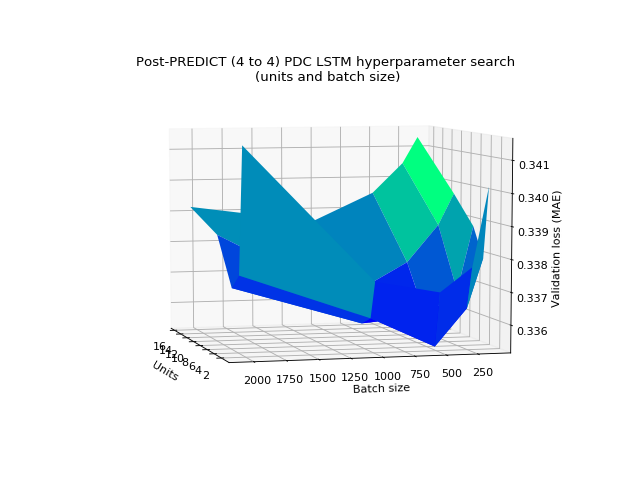

In [31]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits import mplot3d

X,Y = np.meshgrid(x, y)
z = np.array(complete_list)
print(X.shape)
print(Y.shape)
print(z.shape)
fig = pyplot.figure(figsize=(8, 6))
ax = pyplot.axes(projection='3d')

ax.set_xlabel('Units')
ax.set_ylabel('Batch size')
ax.set_zlabel('Validation loss (MAE)')

ax.plot_surface(X, Y, z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title('Post-PREDICT (4 to 4) PDC LSTM hyperparameter search \n(units and batch size)')
pyplot.show()

## Surface plot of h_params (Layer 1 and 2 L2 params)

(175, 6)
(35, 3)


<IPython.core.display.Javascript object>


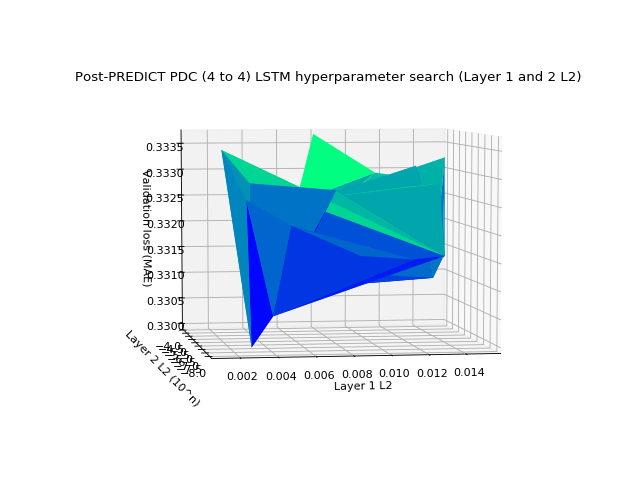

Text(0.5, 0.92, 'Post-PREDICT PDC (4 to 4) LSTM hyperparameter search (Layer 1 and 2 L2)')

In [25]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D   
from mpl_toolkits import mplot3d

# CuDNNLSTM
exp_record = [[2, 512, 0.011503742417395916, 1.5928644630171495e-08, 0, 0.330696214695423], [2, 512, 0.011503742417395916, 1.5928644630171495e-08, 1, 0.3303653117160351], [2, 512, 0.011503742417395916, 1.5928644630171495e-08, 2, 0.3338263375438445], [2, 512, 0.011503742417395916, 1.5928644630171495e-08, 3, 0.3296992521536978], [2, 512, 0.011503742417395916, 1.5928644630171495e-08, 4, 0.33320469053168045], [2, 512, 0.010054533737348428, 1.240504819968725e-06, 0, 0.33244210705422517], [2, 512, 0.010054533737348428, 1.240504819968725e-06, 1, 0.33181475447632414], [2, 512, 0.010054533737348428, 1.240504819968725e-06, 2, 0.33427960874741536], [2, 512, 0.010054533737348428, 1.240504819968725e-06, 3, 0.3286478312879975], [2, 512, 0.010054533737348428, 1.240504819968725e-06, 4, 0.33687255053492315], [2, 512, 0.013786014709215519, 2.1557510587836568e-07, 0, 0.3295556279650906], [2, 512, 0.013786014709215519, 2.1557510587836568e-07, 1, 0.3296908256254698], [2, 512, 0.013786014709215519, 2.1557510587836568e-07, 2, 0.3338570160405678], [2, 512, 0.013786014709215519, 2.1557510587836568e-07, 3, 0.32975371967979344], [2, 512, 0.013786014709215519, 2.1557510587836568e-07, 4, 0.33451254586727297], [2, 512, 0.006818402253715344, 1.4280777442862709e-05, 0, 0.33223618634960106], [2, 512, 0.006818402253715344, 1.4280777442862709e-05, 1, 0.32887674643282305], [2, 512, 0.006818402253715344, 1.4280777442862709e-05, 2, 0.3347611892014219], [2, 512, 0.006818402253715344, 1.4280777442862709e-05, 3, 0.32999238157132915], [2, 512, 0.006818402253715344, 1.4280777442862709e-05, 4, 0.33522172690135], [2, 512, 0.013522330686745972, 5.887009065667275e-08, 0, 0.3308742811247619], [2, 512, 0.013522330686745972, 5.887009065667275e-08, 1, 0.3328217088827613], [2, 512, 0.013522330686745972, 5.887009065667275e-08, 2, 0.33298014452582914], [2, 512, 0.013522330686745972, 5.887009065667275e-08, 3, 0.32835887055648], [2, 512, 0.013522330686745972, 5.887009065667275e-08, 4, 0.3327879531550826], [2, 512, 0.012501362861060105, 5.263268404506872e-06, 0, 0.33273488661002], [2, 512, 0.012501362861060105, 5.263268404506872e-06, 1, 0.33207973748619796], [2, 512, 0.012501362861060105, 5.263268404506872e-06, 2, 0.33417477322600736], [2, 512, 0.012501362861060105, 5.263268404506872e-06, 3, 0.3273650242013541], [2, 512, 0.012501362861060105, 5.263268404506872e-06, 4, 0.33487109520281966], [2, 512, 0.011661016674853225, 6.672000976511281e-06, 0, 0.3339575461407154], [2, 512, 0.011661016674853225, 6.672000976511281e-06, 1, 0.3295798115353835], [2, 512, 0.011661016674853225, 6.672000976511281e-06, 2, 0.3347304419746176], [2, 512, 0.011661016674853225, 6.672000976511281e-06, 3, 0.3302121811024627], [2, 512, 0.011661016674853225, 6.672000976511281e-06, 4, 0.3342184036726143], [2, 512, 0.01487895448275962, 6.199080690569743e-06, 0, 0.3318766562980518], [2, 512, 0.01487895448275962, 6.199080690569743e-06, 1, 0.3322305351391173], [2, 512, 0.01487895448275962, 6.199080690569743e-06, 2, 0.33813083073549105], [2, 512, 0.01487895448275962, 6.199080690569743e-06, 3, 0.3275693065241764], [2, 512, 0.01487895448275962, 6.199080690569743e-06, 4, 0.3364909582528455], [2, 512, 0.007569684226038301, 4.8802536254275044e-08, 0, 0.3343125497249135], [2, 512, 0.007569684226038301, 4.8802536254275044e-08, 1, 0.33244934890702454], [2, 512, 0.007569684226038301, 4.8802536254275044e-08, 2, 0.33342191435440244], [2, 512, 0.007569684226038301, 4.8802536254275044e-08, 3, 0.32994161878412925], [2, 512, 0.007569684226038301, 4.8802536254275044e-08, 4, 0.33376337356037566], [2, 512, 0.005283059252724981, 6.164037108697286e-07, 0, 0.3312062950441015], [2, 512, 0.005283059252724981, 6.164037108697286e-07, 1, 0.33031076858615316], [2, 512, 0.005283059252724981, 6.164037108697286e-07, 2, 0.3333499977114605], [2, 512, 0.005283059252724981, 6.164037108697286e-07, 3, 0.33237614758530554], [2, 512, 0.005283059252724981, 6.164037108697286e-07, 4, 0.33577618538984777], [2, 512, 0.011357191154610015, 1.711159056883078e-05, 0, 0.3326533601785961], [2, 512, 0.011357191154610015, 1.711159056883078e-05, 1, 0.3299518696676221], [2, 512, 0.011357191154610015, 1.711159056883078e-05, 2, 0.33654550472198175], [2, 512, 0.011357191154610015, 1.711159056883078e-05, 3, 0.3286512641042297], [2, 512, 0.011357191154610015, 1.711159056883078e-05, 4, 0.3341741582385281], [2, 512, 0.01347312387486626, 1.389866339919429e-07, 0, 0.3328871206303089], [2, 512, 0.01347312387486626, 1.389866339919429e-07, 1, 0.3315061343204208], [2, 512, 0.01347312387486626, 1.389866339919429e-07, 2, 0.3353458923972838], [2, 512, 0.01347312387486626, 1.389866339919429e-07, 3, 0.3295804456521196], [2, 512, 0.01347312387486626, 1.389866339919429e-07, 4, 0.334945722895059], [2, 512, 0.012361746251160106, 2.757519365696676e-07, 0, 0.33144191615762764], [2, 512, 0.012361746251160106, 2.757519365696676e-07, 1, 0.3317195760994627], [2, 512, 0.012361746251160106, 2.757519365696676e-07, 2, 0.3377762046543478], [2, 512, 0.012361746251160106, 2.757519365696676e-07, 3, 0.3309179220840945], [2, 512, 0.012361746251160106, 2.757519365696676e-07, 4, 0.3340038675871509], [2, 512, 0.005208071119234904, 7.365202206813203e-07, 0, 0.3315437799448158], [2, 512, 0.005208071119234904, 7.365202206813203e-07, 1, 0.3281919132826621], [2, 512, 0.005208071119234904, 7.365202206813203e-07, 2, 0.3328899422235656], [2, 512, 0.005208071119234904, 7.365202206813203e-07, 3, 0.32599598972420946], [2, 512, 0.005208071119234904, 7.365202206813203e-07, 4, 0.3357307079521536], [2, 512, 0.006116031306650328, 5.127295485984823e-07, 0, 0.329101913588786], [2, 512, 0.006116031306650328, 5.127295485984823e-07, 1, 0.3299288381400861], [2, 512, 0.006116031306650328, 5.127295485984823e-07, 2, 0.3343795937613437], [2, 512, 0.006116031306650328, 5.127295485984823e-07, 3, 0.32985366272647476], [2, 512, 0.006116031306650328, 5.127295485984823e-07, 4, 0.33303383991035107], [2, 512, 0.007977237418558597, 8.926266524691063e-05, 0, 0.3329355904581951], [2, 512, 0.007977237418558597, 8.926266524691063e-05, 1, 0.3316555600974992], [2, 512, 0.007977237418558597, 8.926266524691063e-05, 2, 0.33556078466755607], [2, 512, 0.007977237418558597, 8.926266524691063e-05, 3, 0.3332385562107577], [2, 512, 0.007977237418558597, 8.926266524691063e-05, 4, 0.3349975636409737], [2, 512, 0.011869701913398437, 1.6559533069402407e-07, 0, 0.33042377150546737], [2, 512, 0.011869701913398437, 1.6559533069402407e-07, 1, 0.3294680201937581], [2, 512, 0.011869701913398437, 1.6559533069402407e-07, 2, 0.337127840693234], [2, 512, 0.011869701913398437, 1.6559533069402407e-07, 3, 0.33030594159985144], [2, 512, 0.011869701913398437, 1.6559533069402407e-07, 4, 0.3366877951120075], [2, 512, 0.013616260560016462, 7.26713383628764e-07, 0, 0.3300308758961527], [2, 512, 0.013616260560016462, 7.26713383628764e-07, 1, 0.32778849376572505], [2, 512, 0.013616260560016462, 7.26713383628764e-07, 2, 0.3373556469267572], [2, 512, 0.013616260560016462, 7.26713383628764e-07, 3, 0.3260677042760347], [2, 512, 0.013616260560016462, 7.26713383628764e-07, 4, 0.3340539031140288], [2, 512, 0.006986343591837809, 4.8245979822256096e-05, 0, 0.33106061231323153], [2, 512, 0.006986343591837809, 4.8245979822256096e-05, 1, 0.3305133697024563], [2, 512, 0.006986343591837809, 4.8245979822256096e-05, 2, 0.3334461885307267], [2, 512, 0.006986343591837809, 4.8245979822256096e-05, 3, 0.32946011481229326], [2, 512, 0.006986343591837809, 4.8245979822256096e-05, 4, 0.3339596665323826], [2, 512, 0.011571890306104225, 8.81962242466112e-05, 0, 0.3308160005048005], [2, 512, 0.011571890306104225, 8.81962242466112e-05, 1, 0.33181322511176614], [2, 512, 0.011571890306104225, 8.81962242466112e-05, 2, 0.33535629442560744], [2, 512, 0.011571890306104225, 8.81962242466112e-05, 3, 0.32945343714708475], [2, 512, 0.011571890306104225, 8.81962242466112e-05, 4, 0.3371707672473283], [2, 512, 0.01199655628992095, 7.737271559555158e-06, 0, 0.33245071510125324], [2, 512, 0.01199655628992095, 7.737271559555158e-06, 1, 0.3312450687996825], [2, 512, 0.01199655628992095, 7.737271559555158e-06, 2, 0.3362490973904816], [2, 512, 0.01199655628992095, 7.737271559555158e-06, 3, 0.3271318970577062], [2, 512, 0.01199655628992095, 7.737271559555158e-06, 4, 0.3365079014691693], [2, 512, 0.008523924687578462, 1.0243747621637809e-08, 0, 0.33179501645746284], [2, 512, 0.008523924687578462, 1.0243747621637809e-08, 1, 0.3314009416521641], [2, 512, 0.008523924687578462, 1.0243747621637809e-08, 2, 0.3352649327258618], [2, 512, 0.008523924687578462, 1.0243747621637809e-08, 3, 0.3271410960691017], [2, 512, 0.008523924687578462, 1.0243747621637809e-08, 4, 0.3326421720172927], [2, 512, 0.012899605478253064, 1.2519801642602892e-05, 0, 0.3346302626565186], [2, 512, 0.012899605478253064, 1.2519801642602892e-05, 1, 0.3290281228015297], [2, 512, 0.012899605478253064, 1.2519801642602892e-05, 2, 0.3341820516711787], [2, 512, 0.012899605478253064, 1.2519801642602892e-05, 3, 0.32879729315551404], [2, 512, 0.012899605478253064, 1.2519801642602892e-05, 4, 0.33544130296735036], [2, 512, 0.013140479381170484, 3.801356381681079e-05, 0, 0.33282188156891984], [2, 512, 0.013140479381170484, 3.801356381681079e-05, 1, 0.3302968596645266], [2, 512, 0.013140479381170484, 3.801356381681079e-05, 2, 0.33481050268251294], [2, 512, 0.013140479381170484, 3.801356381681079e-05, 3, 0.3311303837396945], [2, 512, 0.013140479381170484, 3.801356381681079e-05, 4, 0.3352141956976283], [2, 512, 0.00697421284502133, 8.605911687398422e-05, 0, 0.3320179354168518], [2, 512, 0.00697421284502133, 8.605911687398422e-05, 1, 0.3318851223535705], [2, 512, 0.00697421284502133, 8.605911687398422e-05, 2, 0.3350405065915738], [2, 512, 0.00697421284502133, 8.605911687398422e-05, 3, 0.3270069602149272], [2, 512, 0.00697421284502133, 8.605911687398422e-05, 4, 0.33584244438779287], [2, 512, 0.003186216573343716, 2.684797464905755e-07, 0, 0.3305093064503363], [2, 512, 0.003186216573343716, 2.684797464905755e-07, 1, 0.332059428231758], [2, 512, 0.003186216573343716, 2.684797464905755e-07, 2, 0.3345476564398983], [2, 512, 0.003186216573343716, 2.684797464905755e-07, 3, 0.3285025851628934], [2, 512, 0.003186216573343716, 2.684797464905755e-07, 4, 0.3353583902643438], [2, 512, 0.004943311839979575, 1.882518469995204e-08, 0, 0.3313169051610936], [2, 512, 0.004943311839979575, 1.882518469995204e-08, 1, 0.3319102282621707], [2, 512, 0.004943311839979575, 1.882518469995204e-08, 2, 0.3336724465980864], [2, 512, 0.004943311839979575, 1.882518469995204e-08, 3, 0.3288021745598107], [2, 512, 0.004943311839979575, 1.882518469995204e-08, 4, 0.33518825427133436], [2, 512, 0.003967719960927292, 8.275603851871003e-07, 0, 0.32858046152438336], [2, 512, 0.003967719960927292, 8.275603851871003e-07, 1, 0.3306632954195926], [2, 512, 0.003967719960927292, 8.275603851871003e-07, 2, 0.3337993780074761], [2, 512, 0.003967719960927292, 8.275603851871003e-07, 3, 0.3289808169233869], [2, 512, 0.003967719960927292, 8.275603851871003e-07, 4, 0.33323491535688704], [2, 512, 0.003485045402996128, 6.071619290197532e-07, 0, 0.3317595636984061], [2, 512, 0.003485045402996128, 6.071619290197532e-07, 1, 0.3284451737947631], [2, 512, 0.003485045402996128, 6.071619290197532e-07, 2, 0.3353798555142698], [2, 512, 0.003485045402996128, 6.071619290197532e-07, 3, 0.33069204506121186], [2, 512, 0.003485045402996128, 6.071619290197532e-07, 4, 0.33670173405206694], [2, 512, 0.004062247659614507, 2.9219979650324778e-08, 0, 0.3293355335059919], [2, 512, 0.004062247659614507, 2.9219979650324778e-08, 1, 0.3316886630323198], [2, 512, 0.004062247659614507, 2.9219979650324778e-08, 2, 0.33249885621126635], [2, 512, 0.004062247659614507, 2.9219979650324778e-08, 3, 0.326440162832974], [2, 512, 0.004062247659614507, 2.9219979650324778e-08, 4, 0.3327512489215672], [2, 512, 0.00255540482114764, 1.239086157209966e-07, 0, 0.3310207402287868], [2, 512, 0.00255540482114764, 1.239086157209966e-07, 1, 0.3315925597307975], [2, 512, 0.00255540482114764, 1.239086157209966e-07, 2, 0.3359579099688614], [2, 512, 0.00255540482114764, 1.239086157209966e-07, 3, 0.328550654614878], [2, 512, 0.00255540482114764, 1.239086157209966e-07, 4, 0.33510361755103396], [2, 512, 0.0014750824400698247, 6.052225129829875e-08, 0, 0.33209546376390064], [2, 512, 0.0014750824400698247, 6.052225129829875e-08, 1, 0.3356662479548426], [2, 512, 0.0014750824400698247, 6.052225129829875e-08, 2, 0.3340554144229108], [2, 512, 0.0014750824400698247, 6.052225129829875e-08, 3, 0.32672893991944385], [2, 512, 0.0014750824400698247, 6.052225129829875e-08, 4, 0.3389865433402926], [2, 512, 0.002648557065322737, 2.8115575062682035e-08, 0, 0.330615975236335], [2, 512, 0.002648557065322737, 2.8115575062682035e-08, 1, 0.3314779954137858], [2, 512, 0.002648557065322737, 2.8115575062682035e-08, 2, 0.33506100656693444], [2, 512, 0.002648557065322737, 2.8115575062682035e-08, 3, 0.3298838086434972], [2, 512, 0.002648557065322737, 2.8115575062682035e-08, 4, 0.33611558108301887], [2, 512, 0.0029314983960859993, 5.2092273309735754e-08, 0, 0.33159611472609446], [2, 512, 0.0029314983960859993, 5.2092273309735754e-08, 1, 0.3286334168771554], [2, 512, 0.0029314983960859993, 5.2092273309735754e-08, 2, 0.33562923987009374], [2, 512, 0.0029314983960859993, 5.2092273309735754e-08, 3, 0.3307660688712583], [2, 512, 0.0029314983960859993, 5.2092273309735754e-08, 4, 0.337942861611383], [2, 512, 0.0029452022278097867, 3.5971913545665144e-08, 0, 0.3284741621547275], [2, 512, 0.0029452022278097867, 3.5971913545665144e-08, 1, 0.3309403525109877], [2, 512, 0.0029452022278097867, 3.5971913545665144e-08, 2, 0.33074402149657756], [2, 512, 0.0029452022278097867, 3.5971913545665144e-08, 3, 0.3263721279582085], [2, 512, 0.0029452022278097867, 3.5971913545665144e-08, 4, 0.33334756425249645]]

# SimpleRNN
#exp_record = [[8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 0, 0.5242269070413378], [8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 1, 0.525349099000295], [8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 2, 0.5365885543823242], [8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 3, 0.5425988081296285], [8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 4, 0.5277500336964925], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 0, 0.5267950610584683], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 1, 0.5295367503696018], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 2, 0.5359356097645229], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 3, 0.5404754420916239], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 4, 0.5256595751444498], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 0, 0.525813970512814], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 1, 0.5298542462454902], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 2, 0.5415794664488899], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 3, 0.5425306218994989], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 4, 0.5260763079060449], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 0, 0.5304228912989298], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 1, 0.5285163696077135], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 2, 0.5386655228932699], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 3, 0.5418453331523472], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 4, 0.5303631690078312], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 0, 0.523647670004103], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 1, 0.5327859327528212], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 2, 0.5376184265878465], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 3, 0.5450782774289449], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 4, 0.5254146420160929], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 0, 0.5255844561258952], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 1, 0.5307434382438659], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 2, 0.53485150358412], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 3, 0.5425920907656352], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 4, 0.5274571968449486], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 0, 0.5232677273750305], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 1, 0.5287924839125739], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 2, 0.5406958606508043], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 3, 0.5436230085160997], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 4, 0.5279602372911242], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 0, 0.5255675659179687], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 1, 0.529599747551812], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 2, 0.5418711858855354], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 3, 0.5419757778909471], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 4, 0.5278487567371792], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 0, 0.5252287040286594], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 1, 0.5298794255786472], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 2, 0.5358870939148797], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 3, 0.5421626020537482], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 4, 0.5251379496786329], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 0, 0.5230150918430753], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 1, 0.5325576625929939], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 2, 0.539261996852027], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 3, 0.5424302851888868], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 4, 0.5274898871845669], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 0, 0.5267839325798882], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 1, 0.5303446153534783], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 2, 0.5385400261349148], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 3, 0.5418429647021823], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 4, 0.5269385030004713], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 0, 0.5313625366952685], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 1, 0.5282620739407009], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 2, 0.5382821731567383], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 3, 0.5451500134997898], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 4, 0.5264901434050666], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 0, 0.5258611058659024], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 1, 0.5295188352266947], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 2, 0.5405661355654399], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 3, 0.5411439078119066], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 4, 0.5269565528763666], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 0, 0.5248532167010838], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 1, 0.5287763313717312], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 2, 0.5372731739150153], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 3, 0.540460501352946], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 4, 0.5239714206589593], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 0, 0.5258303877512613], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 1, 0.5287323527336121], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 2, 0.5389482663472493], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 3, 0.5430828909873963], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 4, 0.5255136568811205], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 0, 0.5231563124126858], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 1, 0.5301885165638394], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 2, 0.5362451896667481], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 3, 0.5419134329160055], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 4, 0.5271275286144681], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 0, 0.5255752742025588], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 1, 0.5302510392400953], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 2, 0.5363814177513122], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 3, 0.5430691199302673], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 4, 0.5260621473259396], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 0, 0.526260646502177], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 1, 0.527542490694258], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 2, 0.5388704651726617], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 3, 0.5417022616068522], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 4, 0.525114941491021], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 0, 0.5263720021777683], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 1, 0.5278960639105903], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 2, 0.5385342162979974], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 3, 0.5443284500439962], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 4, 0.5268172572718727], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 0, 0.5246620207892524], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 1, 0.529846426539951], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 2, 0.5376503368483649], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 3, 0.5387413437101576], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 4, 0.5287924146917131], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 0, 0.5269467938211229], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 1, 0.528441904703776], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 2, 0.5390637372334798], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 3, 0.5433187580638462], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 4, 0.5264804084565904], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 0, 0.5252114715046353], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 1, 0.530470426135593], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 2, 0.5382516849305895], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 3, 0.5405394402609931], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 4, 0.527427950806088], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 0, 0.5258517005708483], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 1, 0.5317648502985637], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 2, 0.5364585013389588], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 3, 0.542794468720754], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 4, 0.5245460402170817], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 0, 0.5240845356517367], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 1, 0.5332800193892585], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 2, 0.5365430009100173], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 3, 0.5374082610872056], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 4, 0.5279359411133661], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 0, 0.5259121624098884], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 1, 0.52997758436203], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 2, 0.5415159805615744], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 3, 0.540463439517551], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 4, 0.5234653304153019]]

complete_v = np.array(exp_record)
print(complete_v.shape)
xyz = []
for i in range(35):
    fold_v = complete_v[(i*5):((i+1)*5), :]
    xyz.append([fold_v[0, 2], 
                fold_v[0, 3], 
                np.mean(fold_v[:, 5])])
xyz_v = np.array(xyz)
print(xyz_v.shape)
xyz_v[:, 1] = np.log10(xyz_v[:, 1])

fig = pyplot.figure(figsize=(8, 6))

ax = pyplot.axes(projection='3d')
ax.set_xlabel('Layer 1 L2')
ax.set_ylabel('Layer 2 L2 (10^n)')
ax.set_zlabel('Validation loss (MAE)')

ax.plot_trisurf(xyz_v[:, 0], xyz_v[:, 1], xyz_v[:, 2],
               cmap='winter', edgecolor='none')
ax.set_title('Post-PREDICT PDC (4 to 4) LSTM hyperparameter search (Layer 1 and 2 L2)')